# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

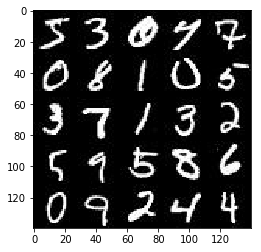

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

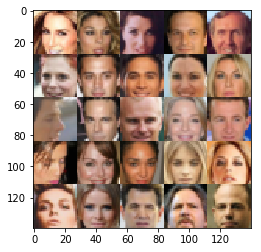

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\KevinRuan\AppData\Local\conda\conda\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout_rate = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28*28*3
        initializer1 = tf.contrib.layers.xavier_initializer()
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=initializer1)
        relu1 = tf.maximum(alpha * x1, x1)
        relu1=tf.identity(relu1,name="relu1")
        # 14 * 14 * 64
        
        initializer2 = tf.contrib.layers.xavier_initializer()
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=initializer2)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2=tf.identity(relu2,name="relu2")
        # 7 * 7 * 128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flat, 1)
        logits=tf.identity(logits,name="logits")
        logits = tf.layers.dropout(logits, rate=dropout_rate, training=True)
        out =tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1=tf.identity(x1,name="x1")
        # 7 * 7 * 128
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2=tf.identity(x2,name="x2")
        # 14 * 14 * 64
              
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28 * 28 * out_channel_dim
        
        out = tf.tanh(logits)
        out=tf.identity(out,name="logits")

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                   labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars, name="d_train_opt")
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars, name="g_train_opt")    

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model     
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    if data_image_mode == "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1  
        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images,
                                                     input_z:batch_z,
                                                    input_learning_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images,
                                                     input_z:batch_z,
                                                    input_learning_rate:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z,input_real:batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                            "Step: {}...".format(steps),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, out_channel_dim, data_image_mode)
                    
                
                
                
                
                
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Step: 10... Discriminator Loss: 3.9181... Generator Loss: 0.5763
Epoch 0/2... Step: 20... Discriminator Loss: 1.9299... Generator Loss: 2.2380
Epoch 0/2... Step: 30... Discriminator Loss: 2.4518... Generator Loss: 0.7699
Epoch 0/2... Step: 40... Discriminator Loss: 2.0239... Generator Loss: 1.3289
Epoch 0/2... Step: 50... Discriminator Loss: 1.5987... Generator Loss: 1.2908
Epoch 0/2... Step: 60... Discriminator Loss: 1.9610... Generator Loss: 0.9079
Epoch 0/2... Step: 70... Discriminator Loss: 1.9807... Generator Loss: 0.6114
Epoch 0/2... Step: 80... Discriminator Loss: 2.1117... Generator Loss: 1.7712
Epoch 0/2... Step: 90... Discriminator Loss: 1.6868... Generator Loss: 0.8595
Epoch 0/2... Step: 100... Discriminator Loss: 1.6948... Generator Loss: 0.7339


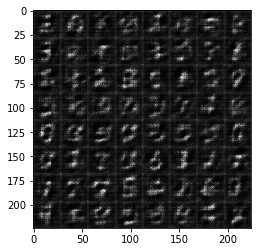

Epoch 0/2... Step: 110... Discriminator Loss: 2.1064... Generator Loss: 0.6726
Epoch 0/2... Step: 120... Discriminator Loss: 1.7531... Generator Loss: 0.9457
Epoch 0/2... Step: 130... Discriminator Loss: 1.5847... Generator Loss: 0.9284
Epoch 0/2... Step: 140... Discriminator Loss: 1.6427... Generator Loss: 0.8459
Epoch 0/2... Step: 150... Discriminator Loss: 1.7125... Generator Loss: 0.7511
Epoch 0/2... Step: 160... Discriminator Loss: 2.0453... Generator Loss: 0.8703
Epoch 0/2... Step: 170... Discriminator Loss: 2.3158... Generator Loss: 2.1929
Epoch 0/2... Step: 180... Discriminator Loss: 1.6945... Generator Loss: 0.7481
Epoch 0/2... Step: 190... Discriminator Loss: 2.4370... Generator Loss: 2.9343
Epoch 0/2... Step: 200... Discriminator Loss: 1.8360... Generator Loss: 1.5193


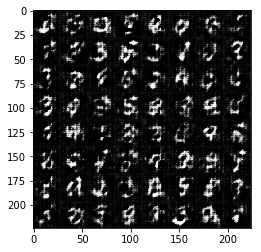

Epoch 0/2... Step: 210... Discriminator Loss: 1.5737... Generator Loss: 1.0639
Epoch 0/2... Step: 220... Discriminator Loss: 1.4044... Generator Loss: 1.0406
Epoch 0/2... Step: 230... Discriminator Loss: 1.6024... Generator Loss: 0.7310
Epoch 0/2... Step: 240... Discriminator Loss: 1.5542... Generator Loss: 0.7011
Epoch 0/2... Step: 250... Discriminator Loss: 1.5685... Generator Loss: 0.7456
Epoch 0/2... Step: 260... Discriminator Loss: 1.5335... Generator Loss: 1.3322
Epoch 0/2... Step: 270... Discriminator Loss: 1.4638... Generator Loss: 1.3596
Epoch 0/2... Step: 280... Discriminator Loss: 1.5465... Generator Loss: 0.6584
Epoch 0/2... Step: 290... Discriminator Loss: 1.6341... Generator Loss: 1.6410
Epoch 0/2... Step: 300... Discriminator Loss: 1.5267... Generator Loss: 0.8402


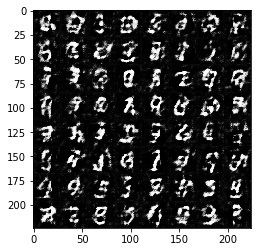

Epoch 0/2... Step: 310... Discriminator Loss: 1.6008... Generator Loss: 0.6442
Epoch 0/2... Step: 320... Discriminator Loss: 1.3403... Generator Loss: 1.5760
Epoch 0/2... Step: 330... Discriminator Loss: 1.6033... Generator Loss: 1.6283
Epoch 0/2... Step: 340... Discriminator Loss: 1.8393... Generator Loss: 1.8789
Epoch 0/2... Step: 350... Discriminator Loss: 1.3944... Generator Loss: 1.0826
Epoch 0/2... Step: 360... Discriminator Loss: 1.5708... Generator Loss: 0.5890
Epoch 0/2... Step: 370... Discriminator Loss: 1.6939... Generator Loss: 1.2108
Epoch 0/2... Step: 380... Discriminator Loss: 1.3935... Generator Loss: 0.9784
Epoch 0/2... Step: 390... Discriminator Loss: 1.5287... Generator Loss: 1.2731
Epoch 0/2... Step: 400... Discriminator Loss: 1.6255... Generator Loss: 0.9948


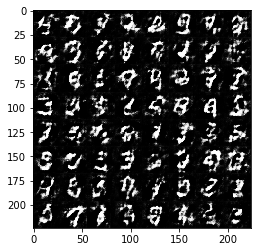

Epoch 0/2... Step: 410... Discriminator Loss: 1.5164... Generator Loss: 0.7324
Epoch 0/2... Step: 420... Discriminator Loss: 1.4726... Generator Loss: 1.3499
Epoch 0/2... Step: 430... Discriminator Loss: 1.4372... Generator Loss: 0.8420
Epoch 0/2... Step: 440... Discriminator Loss: 1.3892... Generator Loss: 0.8023
Epoch 0/2... Step: 450... Discriminator Loss: 1.5475... Generator Loss: 0.8195
Epoch 0/2... Step: 460... Discriminator Loss: 1.3708... Generator Loss: 0.9375
Epoch 0/2... Step: 470... Discriminator Loss: 1.3375... Generator Loss: 0.9412
Epoch 0/2... Step: 480... Discriminator Loss: 1.2705... Generator Loss: 1.5194
Epoch 0/2... Step: 490... Discriminator Loss: 1.6581... Generator Loss: 0.7014
Epoch 0/2... Step: 500... Discriminator Loss: 1.6822... Generator Loss: 0.7059


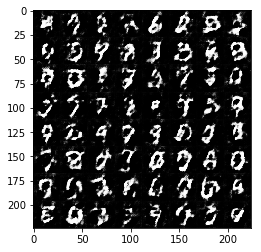

Epoch 0/2... Step: 510... Discriminator Loss: 1.6783... Generator Loss: 1.3778
Epoch 0/2... Step: 520... Discriminator Loss: 1.4057... Generator Loss: 1.2419
Epoch 0/2... Step: 530... Discriminator Loss: 1.3785... Generator Loss: 0.7672
Epoch 0/2... Step: 540... Discriminator Loss: 2.0962... Generator Loss: 0.5567
Epoch 0/2... Step: 550... Discriminator Loss: 1.5334... Generator Loss: 1.5122
Epoch 0/2... Step: 560... Discriminator Loss: 1.3908... Generator Loss: 1.0551
Epoch 0/2... Step: 570... Discriminator Loss: 1.3916... Generator Loss: 0.6659
Epoch 0/2... Step: 580... Discriminator Loss: 1.4369... Generator Loss: 0.7937
Epoch 0/2... Step: 590... Discriminator Loss: 1.2993... Generator Loss: 1.0531
Epoch 0/2... Step: 600... Discriminator Loss: 1.3473... Generator Loss: 1.2508


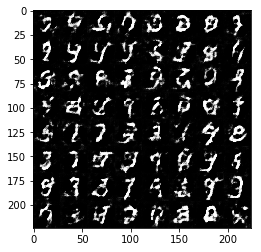

Epoch 0/2... Step: 610... Discriminator Loss: 1.3709... Generator Loss: 0.8986
Epoch 0/2... Step: 620... Discriminator Loss: 1.5507... Generator Loss: 1.1737
Epoch 0/2... Step: 630... Discriminator Loss: 1.4004... Generator Loss: 1.2440
Epoch 0/2... Step: 640... Discriminator Loss: 1.3981... Generator Loss: 1.0988
Epoch 0/2... Step: 650... Discriminator Loss: 1.3320... Generator Loss: 0.7501
Epoch 0/2... Step: 660... Discriminator Loss: 1.4475... Generator Loss: 0.8006
Epoch 0/2... Step: 670... Discriminator Loss: 1.2845... Generator Loss: 1.0130
Epoch 0/2... Step: 680... Discriminator Loss: 1.3824... Generator Loss: 0.8985
Epoch 0/2... Step: 690... Discriminator Loss: 1.3809... Generator Loss: 0.8485
Epoch 0/2... Step: 700... Discriminator Loss: 1.4151... Generator Loss: 1.2033


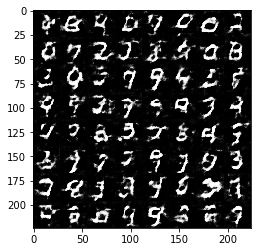

Epoch 0/2... Step: 710... Discriminator Loss: 1.6219... Generator Loss: 1.7054
Epoch 0/2... Step: 720... Discriminator Loss: 1.4365... Generator Loss: 0.8638
Epoch 0/2... Step: 730... Discriminator Loss: 1.4187... Generator Loss: 0.6235
Epoch 0/2... Step: 740... Discriminator Loss: 1.2623... Generator Loss: 0.9231
Epoch 0/2... Step: 750... Discriminator Loss: 1.6293... Generator Loss: 0.9268
Epoch 0/2... Step: 760... Discriminator Loss: 1.3675... Generator Loss: 1.1032
Epoch 0/2... Step: 770... Discriminator Loss: 1.2877... Generator Loss: 0.7258
Epoch 0/2... Step: 780... Discriminator Loss: 1.3585... Generator Loss: 0.9122
Epoch 0/2... Step: 790... Discriminator Loss: 1.3763... Generator Loss: 0.9920
Epoch 0/2... Step: 800... Discriminator Loss: 1.2923... Generator Loss: 0.7819


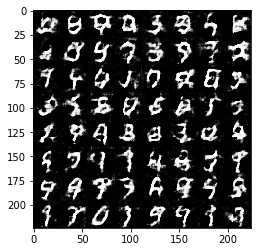

Epoch 0/2... Step: 810... Discriminator Loss: 1.3549... Generator Loss: 0.7718
Epoch 0/2... Step: 820... Discriminator Loss: 1.3286... Generator Loss: 0.7441
Epoch 0/2... Step: 830... Discriminator Loss: 1.6039... Generator Loss: 1.1623
Epoch 0/2... Step: 840... Discriminator Loss: 1.3568... Generator Loss: 1.1413
Epoch 0/2... Step: 850... Discriminator Loss: 1.4176... Generator Loss: 0.8020
Epoch 0/2... Step: 860... Discriminator Loss: 1.5103... Generator Loss: 1.8250
Epoch 0/2... Step: 870... Discriminator Loss: 1.7332... Generator Loss: 0.5667
Epoch 0/2... Step: 880... Discriminator Loss: 1.7236... Generator Loss: 0.6248
Epoch 0/2... Step: 890... Discriminator Loss: 1.5870... Generator Loss: 1.1154
Epoch 0/2... Step: 900... Discriminator Loss: 1.5494... Generator Loss: 0.7201


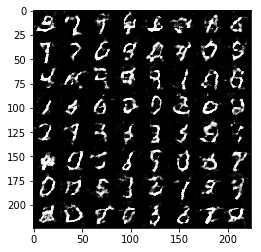

Epoch 0/2... Step: 910... Discriminator Loss: 1.3712... Generator Loss: 0.6851
Epoch 0/2... Step: 920... Discriminator Loss: 1.5815... Generator Loss: 1.3173
Epoch 0/2... Step: 930... Discriminator Loss: 1.3425... Generator Loss: 0.9276
Epoch 1/2... Step: 940... Discriminator Loss: 1.4276... Generator Loss: 1.2460
Epoch 1/2... Step: 950... Discriminator Loss: 1.4733... Generator Loss: 0.9293
Epoch 1/2... Step: 960... Discriminator Loss: 1.6493... Generator Loss: 1.5571
Epoch 1/2... Step: 970... Discriminator Loss: 1.4530... Generator Loss: 0.9204
Epoch 1/2... Step: 980... Discriminator Loss: 1.3585... Generator Loss: 1.7152
Epoch 1/2... Step: 990... Discriminator Loss: 1.5571... Generator Loss: 0.7008
Epoch 1/2... Step: 1000... Discriminator Loss: 1.3849... Generator Loss: 0.8014


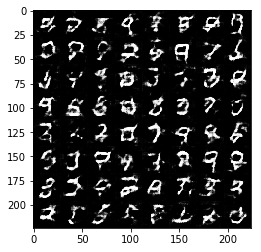

Epoch 1/2... Step: 1010... Discriminator Loss: 1.3369... Generator Loss: 0.9515
Epoch 1/2... Step: 1020... Discriminator Loss: 1.4012... Generator Loss: 0.9761
Epoch 1/2... Step: 1030... Discriminator Loss: 1.3143... Generator Loss: 0.8726
Epoch 1/2... Step: 1040... Discriminator Loss: 1.3053... Generator Loss: 1.0152
Epoch 1/2... Step: 1050... Discriminator Loss: 1.4439... Generator Loss: 1.2517
Epoch 1/2... Step: 1060... Discriminator Loss: 1.3085... Generator Loss: 1.2159
Epoch 1/2... Step: 1070... Discriminator Loss: 1.4516... Generator Loss: 1.2292
Epoch 1/2... Step: 1080... Discriminator Loss: 1.7825... Generator Loss: 0.6162
Epoch 1/2... Step: 1090... Discriminator Loss: 1.3690... Generator Loss: 0.8883
Epoch 1/2... Step: 1100... Discriminator Loss: 1.5036... Generator Loss: 0.7819


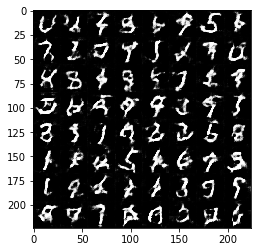

Epoch 1/2... Step: 1110... Discriminator Loss: 1.2911... Generator Loss: 0.9375
Epoch 1/2... Step: 1120... Discriminator Loss: 1.3997... Generator Loss: 0.7621
Epoch 1/2... Step: 1130... Discriminator Loss: 1.4397... Generator Loss: 0.6820
Epoch 1/2... Step: 1140... Discriminator Loss: 1.4883... Generator Loss: 0.6708
Epoch 1/2... Step: 1150... Discriminator Loss: 1.5808... Generator Loss: 0.6334
Epoch 1/2... Step: 1160... Discriminator Loss: 1.3526... Generator Loss: 1.2373
Epoch 1/2... Step: 1170... Discriminator Loss: 1.5069... Generator Loss: 0.7568
Epoch 1/2... Step: 1180... Discriminator Loss: 1.5076... Generator Loss: 1.3878
Epoch 1/2... Step: 1190... Discriminator Loss: 1.3718... Generator Loss: 1.1420
Epoch 1/2... Step: 1200... Discriminator Loss: 1.4759... Generator Loss: 1.1774


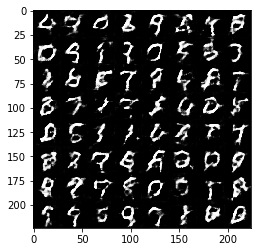

Epoch 1/2... Step: 1210... Discriminator Loss: 1.4085... Generator Loss: 0.9254
Epoch 1/2... Step: 1220... Discriminator Loss: 1.3913... Generator Loss: 0.7521
Epoch 1/2... Step: 1230... Discriminator Loss: 1.4176... Generator Loss: 0.7631
Epoch 1/2... Step: 1240... Discriminator Loss: 1.4286... Generator Loss: 0.7816
Epoch 1/2... Step: 1250... Discriminator Loss: 1.4552... Generator Loss: 0.5944
Epoch 1/2... Step: 1260... Discriminator Loss: 1.4584... Generator Loss: 0.6888
Epoch 1/2... Step: 1270... Discriminator Loss: 1.3430... Generator Loss: 0.7247
Epoch 1/2... Step: 1280... Discriminator Loss: 1.4777... Generator Loss: 1.5166
Epoch 1/2... Step: 1290... Discriminator Loss: 1.4809... Generator Loss: 0.7315
Epoch 1/2... Step: 1300... Discriminator Loss: 1.5598... Generator Loss: 1.2037


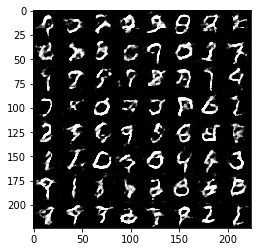

Epoch 1/2... Step: 1310... Discriminator Loss: 1.4233... Generator Loss: 0.9110
Epoch 1/2... Step: 1320... Discriminator Loss: 1.3836... Generator Loss: 0.9801
Epoch 1/2... Step: 1330... Discriminator Loss: 1.3385... Generator Loss: 0.8696
Epoch 1/2... Step: 1340... Discriminator Loss: 1.4237... Generator Loss: 0.7177
Epoch 1/2... Step: 1350... Discriminator Loss: 1.4138... Generator Loss: 0.6888
Epoch 1/2... Step: 1360... Discriminator Loss: 1.5016... Generator Loss: 1.2075
Epoch 1/2... Step: 1370... Discriminator Loss: 1.5539... Generator Loss: 0.8433
Epoch 1/2... Step: 1380... Discriminator Loss: 1.3378... Generator Loss: 1.1762
Epoch 1/2... Step: 1390... Discriminator Loss: 1.2757... Generator Loss: 0.8989
Epoch 1/2... Step: 1400... Discriminator Loss: 1.6738... Generator Loss: 0.6327


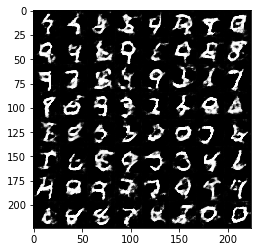

Epoch 1/2... Step: 1410... Discriminator Loss: 1.4033... Generator Loss: 0.8596
Epoch 1/2... Step: 1420... Discriminator Loss: 1.3450... Generator Loss: 1.6108
Epoch 1/2... Step: 1430... Discriminator Loss: 1.5359... Generator Loss: 0.7030
Epoch 1/2... Step: 1440... Discriminator Loss: 1.5236... Generator Loss: 0.7558
Epoch 1/2... Step: 1450... Discriminator Loss: 1.6465... Generator Loss: 1.2332
Epoch 1/2... Step: 1460... Discriminator Loss: 1.4347... Generator Loss: 1.0351
Epoch 1/2... Step: 1470... Discriminator Loss: 1.3173... Generator Loss: 0.7423
Epoch 1/2... Step: 1480... Discriminator Loss: 1.3841... Generator Loss: 0.8797
Epoch 1/2... Step: 1490... Discriminator Loss: 1.3415... Generator Loss: 1.2719
Epoch 1/2... Step: 1500... Discriminator Loss: 1.2992... Generator Loss: 0.9969


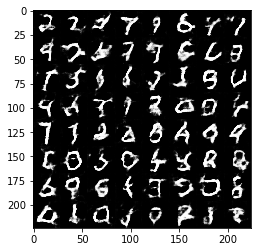

Epoch 1/2... Step: 1510... Discriminator Loss: 1.4470... Generator Loss: 0.7341
Epoch 1/2... Step: 1520... Discriminator Loss: 1.3467... Generator Loss: 0.8495
Epoch 1/2... Step: 1530... Discriminator Loss: 1.3323... Generator Loss: 1.0790
Epoch 1/2... Step: 1540... Discriminator Loss: 1.4205... Generator Loss: 1.0618
Epoch 1/2... Step: 1550... Discriminator Loss: 1.2421... Generator Loss: 0.8455
Epoch 1/2... Step: 1560... Discriminator Loss: 1.3322... Generator Loss: 0.8513
Epoch 1/2... Step: 1570... Discriminator Loss: 1.4120... Generator Loss: 0.9560
Epoch 1/2... Step: 1580... Discriminator Loss: 1.3969... Generator Loss: 1.3744
Epoch 1/2... Step: 1590... Discriminator Loss: 1.5519... Generator Loss: 0.6246
Epoch 1/2... Step: 1600... Discriminator Loss: 1.3648... Generator Loss: 0.8669


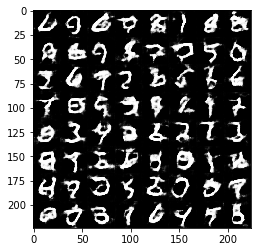

Epoch 1/2... Step: 1610... Discriminator Loss: 1.4410... Generator Loss: 0.8735
Epoch 1/2... Step: 1620... Discriminator Loss: 1.3401... Generator Loss: 0.7191
Epoch 1/2... Step: 1630... Discriminator Loss: 1.5135... Generator Loss: 0.9605
Epoch 1/2... Step: 1640... Discriminator Loss: 1.4902... Generator Loss: 0.8918
Epoch 1/2... Step: 1650... Discriminator Loss: 1.4063... Generator Loss: 0.9673
Epoch 1/2... Step: 1660... Discriminator Loss: 1.2563... Generator Loss: 1.1045
Epoch 1/2... Step: 1670... Discriminator Loss: 1.4000... Generator Loss: 0.6856
Epoch 1/2... Step: 1680... Discriminator Loss: 1.2546... Generator Loss: 1.1872
Epoch 1/2... Step: 1690... Discriminator Loss: 1.3771... Generator Loss: 0.9035
Epoch 1/2... Step: 1700... Discriminator Loss: 1.3505... Generator Loss: 0.8553


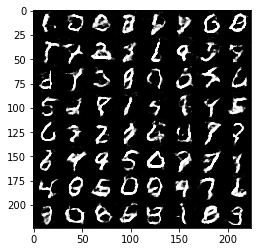

Epoch 1/2... Step: 1710... Discriminator Loss: 1.7144... Generator Loss: 0.5921
Epoch 1/2... Step: 1720... Discriminator Loss: 1.3211... Generator Loss: 0.7392
Epoch 1/2... Step: 1730... Discriminator Loss: 1.3456... Generator Loss: 0.9680
Epoch 1/2... Step: 1740... Discriminator Loss: 1.6576... Generator Loss: 1.2476
Epoch 1/2... Step: 1750... Discriminator Loss: 1.4378... Generator Loss: 0.7198
Epoch 1/2... Step: 1760... Discriminator Loss: 1.7507... Generator Loss: 2.1802
Epoch 1/2... Step: 1770... Discriminator Loss: 1.5582... Generator Loss: 1.2857
Epoch 1/2... Step: 1780... Discriminator Loss: 1.4222... Generator Loss: 0.9278
Epoch 1/2... Step: 1790... Discriminator Loss: 1.3306... Generator Loss: 0.6971
Epoch 1/2... Step: 1800... Discriminator Loss: 1.3648... Generator Loss: 0.8154


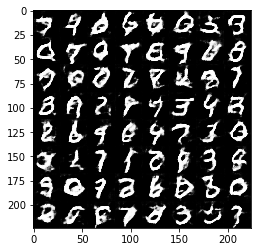

Epoch 1/2... Step: 1810... Discriminator Loss: 1.4380... Generator Loss: 0.7447
Epoch 1/2... Step: 1820... Discriminator Loss: 1.4833... Generator Loss: 0.7447
Epoch 1/2... Step: 1830... Discriminator Loss: 1.6441... Generator Loss: 1.3786
Epoch 1/2... Step: 1840... Discriminator Loss: 1.3027... Generator Loss: 1.0363
Epoch 1/2... Step: 1850... Discriminator Loss: 1.2764... Generator Loss: 0.7889
Epoch 1/2... Step: 1860... Discriminator Loss: 1.3399... Generator Loss: 0.7819
Epoch 1/2... Step: 1870... Discriminator Loss: 1.3949... Generator Loss: 1.3717


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Step: 10... Discriminator Loss: 1.9222... Generator Loss: 5.0020
Epoch 0/1... Step: 20... Discriminator Loss: 1.5879... Generator Loss: 3.4917
Epoch 0/1... Step: 30... Discriminator Loss: 2.6140... Generator Loss: 3.7735
Epoch 0/1... Step: 40... Discriminator Loss: 1.3775... Generator Loss: 2.8954
Epoch 0/1... Step: 50... Discriminator Loss: 2.1752... Generator Loss: 1.6620
Epoch 0/1... Step: 60... Discriminator Loss: 1.3547... Generator Loss: 2.5122
Epoch 0/1... Step: 70... Discriminator Loss: 2.3084... Generator Loss: 3.0286
Epoch 0/1... Step: 80... Discriminator Loss: 2.6470... Generator Loss: 0.9314
Epoch 0/1... Step: 90... Discriminator Loss: 1.7028... Generator Loss: 0.6463
Epoch 0/1... Step: 100... Discriminator Loss: 1.4306... Generator Loss: 1.7079


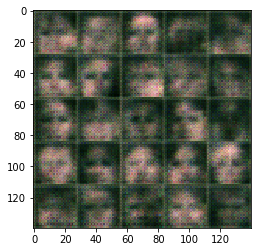

Epoch 0/1... Step: 110... Discriminator Loss: 1.7492... Generator Loss: 1.9356
Epoch 0/1... Step: 120... Discriminator Loss: 2.2551... Generator Loss: 6.3085
Epoch 0/1... Step: 130... Discriminator Loss: 1.7859... Generator Loss: 1.2790
Epoch 0/1... Step: 140... Discriminator Loss: 2.3080... Generator Loss: 3.3497
Epoch 0/1... Step: 150... Discriminator Loss: 1.6897... Generator Loss: 2.2870
Epoch 0/1... Step: 160... Discriminator Loss: 3.7614... Generator Loss: 0.6083
Epoch 0/1... Step: 170... Discriminator Loss: 1.7753... Generator Loss: 1.2525
Epoch 0/1... Step: 180... Discriminator Loss: 1.9932... Generator Loss: 0.7383
Epoch 0/1... Step: 190... Discriminator Loss: 1.2755... Generator Loss: 4.2002
Epoch 0/1... Step: 200... Discriminator Loss: 1.6602... Generator Loss: 1.1828


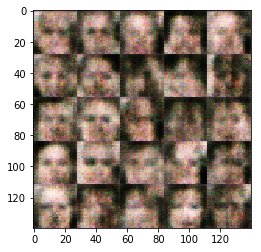

Epoch 0/1... Step: 210... Discriminator Loss: 1.7024... Generator Loss: 1.0085
Epoch 0/1... Step: 220... Discriminator Loss: 1.7845... Generator Loss: 2.4170
Epoch 0/1... Step: 230... Discriminator Loss: 2.1393... Generator Loss: 0.6948
Epoch 0/1... Step: 240... Discriminator Loss: 1.9956... Generator Loss: 0.7567
Epoch 0/1... Step: 250... Discriminator Loss: 1.8044... Generator Loss: 1.7801
Epoch 0/1... Step: 260... Discriminator Loss: 2.4804... Generator Loss: 1.1067
Epoch 0/1... Step: 270... Discriminator Loss: 1.7851... Generator Loss: 1.2220
Epoch 0/1... Step: 280... Discriminator Loss: 1.8801... Generator Loss: 1.7089
Epoch 0/1... Step: 290... Discriminator Loss: 2.8277... Generator Loss: 0.9582
Epoch 0/1... Step: 300... Discriminator Loss: 1.9606... Generator Loss: 0.6351


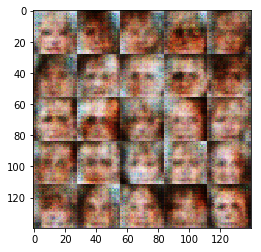

Epoch 0/1... Step: 310... Discriminator Loss: 1.3661... Generator Loss: 1.2378
Epoch 0/1... Step: 320... Discriminator Loss: 2.0777... Generator Loss: 0.8249
Epoch 0/1... Step: 330... Discriminator Loss: 1.3967... Generator Loss: 0.8147
Epoch 0/1... Step: 340... Discriminator Loss: 1.2891... Generator Loss: 1.2384
Epoch 0/1... Step: 350... Discriminator Loss: 2.2343... Generator Loss: 1.2993
Epoch 0/1... Step: 360... Discriminator Loss: 1.6333... Generator Loss: 0.7949
Epoch 0/1... Step: 370... Discriminator Loss: 1.5623... Generator Loss: 1.1262
Epoch 0/1... Step: 380... Discriminator Loss: 1.5164... Generator Loss: 1.4424
Epoch 0/1... Step: 390... Discriminator Loss: 1.4851... Generator Loss: 1.0981
Epoch 0/1... Step: 400... Discriminator Loss: 1.3751... Generator Loss: 1.0512


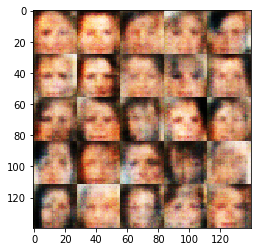

Epoch 0/1... Step: 410... Discriminator Loss: 1.8366... Generator Loss: 0.7160
Epoch 0/1... Step: 420... Discriminator Loss: 1.7541... Generator Loss: 0.6589
Epoch 0/1... Step: 430... Discriminator Loss: 2.0444... Generator Loss: 0.7194
Epoch 0/1... Step: 440... Discriminator Loss: 2.3803... Generator Loss: 0.6324
Epoch 0/1... Step: 450... Discriminator Loss: 2.4009... Generator Loss: 2.2202
Epoch 0/1... Step: 460... Discriminator Loss: 1.3775... Generator Loss: 1.3052
Epoch 0/1... Step: 470... Discriminator Loss: 2.0281... Generator Loss: 1.2223
Epoch 0/1... Step: 480... Discriminator Loss: 1.9949... Generator Loss: 1.1560
Epoch 0/1... Step: 490... Discriminator Loss: 1.3170... Generator Loss: 0.7332
Epoch 0/1... Step: 500... Discriminator Loss: 2.7886... Generator Loss: 0.7515


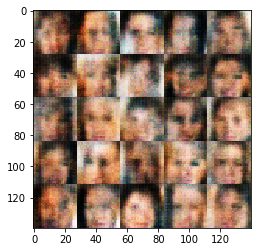

Epoch 0/1... Step: 510... Discriminator Loss: 1.3644... Generator Loss: 1.1847
Epoch 0/1... Step: 520... Discriminator Loss: 1.5573... Generator Loss: 0.7414
Epoch 0/1... Step: 530... Discriminator Loss: 1.2915... Generator Loss: 0.8126
Epoch 0/1... Step: 540... Discriminator Loss: 2.1710... Generator Loss: 0.6087
Epoch 0/1... Step: 550... Discriminator Loss: 1.6694... Generator Loss: 0.8227
Epoch 0/1... Step: 560... Discriminator Loss: 1.4718... Generator Loss: 1.0679
Epoch 0/1... Step: 570... Discriminator Loss: 1.4246... Generator Loss: 0.8388
Epoch 0/1... Step: 580... Discriminator Loss: 1.7497... Generator Loss: 0.9345
Epoch 0/1... Step: 590... Discriminator Loss: 1.8070... Generator Loss: 1.5194
Epoch 0/1... Step: 600... Discriminator Loss: 1.4538... Generator Loss: 1.1598


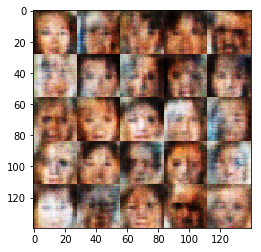

Epoch 0/1... Step: 610... Discriminator Loss: 1.5209... Generator Loss: 0.7624
Epoch 0/1... Step: 620... Discriminator Loss: 1.6524... Generator Loss: 0.9581
Epoch 0/1... Step: 630... Discriminator Loss: 1.6530... Generator Loss: 0.8043
Epoch 0/1... Step: 640... Discriminator Loss: 1.7481... Generator Loss: 0.8641
Epoch 0/1... Step: 650... Discriminator Loss: 1.8709... Generator Loss: 0.6554
Epoch 0/1... Step: 660... Discriminator Loss: 1.5740... Generator Loss: 0.8728
Epoch 0/1... Step: 670... Discriminator Loss: 1.5868... Generator Loss: 1.2167
Epoch 0/1... Step: 680... Discriminator Loss: 2.1698... Generator Loss: 0.9321
Epoch 0/1... Step: 690... Discriminator Loss: 1.4865... Generator Loss: 1.3707
Epoch 0/1... Step: 700... Discriminator Loss: 1.8046... Generator Loss: 0.9739


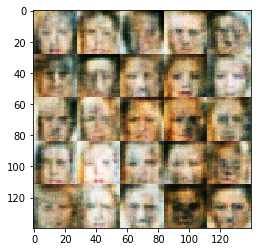

Epoch 0/1... Step: 710... Discriminator Loss: 1.6456... Generator Loss: 1.2802
Epoch 0/1... Step: 720... Discriminator Loss: 1.5964... Generator Loss: 0.8888
Epoch 0/1... Step: 730... Discriminator Loss: 1.5678... Generator Loss: 0.6463
Epoch 0/1... Step: 740... Discriminator Loss: 1.3183... Generator Loss: 1.0311
Epoch 0/1... Step: 750... Discriminator Loss: 1.3803... Generator Loss: 0.7908
Epoch 0/1... Step: 760... Discriminator Loss: 1.8099... Generator Loss: 1.2541
Epoch 0/1... Step: 770... Discriminator Loss: 1.9205... Generator Loss: 0.9632
Epoch 0/1... Step: 780... Discriminator Loss: 1.3680... Generator Loss: 0.7983
Epoch 0/1... Step: 790... Discriminator Loss: 1.4987... Generator Loss: 0.5603
Epoch 0/1... Step: 800... Discriminator Loss: 1.3930... Generator Loss: 1.0053


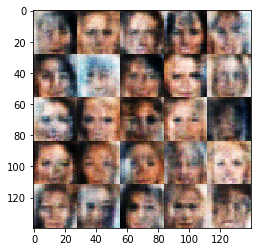

Epoch 0/1... Step: 810... Discriminator Loss: 1.6670... Generator Loss: 1.2317
Epoch 0/1... Step: 820... Discriminator Loss: 1.6191... Generator Loss: 0.7370
Epoch 0/1... Step: 830... Discriminator Loss: 1.6142... Generator Loss: 0.8674
Epoch 0/1... Step: 840... Discriminator Loss: 1.3902... Generator Loss: 0.9238
Epoch 0/1... Step: 850... Discriminator Loss: 1.5596... Generator Loss: 1.2489
Epoch 0/1... Step: 860... Discriminator Loss: 1.5170... Generator Loss: 0.8629
Epoch 0/1... Step: 870... Discriminator Loss: 1.8601... Generator Loss: 0.6299
Epoch 0/1... Step: 880... Discriminator Loss: 1.6071... Generator Loss: 0.6836
Epoch 0/1... Step: 890... Discriminator Loss: 1.6046... Generator Loss: 1.1272
Epoch 0/1... Step: 900... Discriminator Loss: 1.8519... Generator Loss: 1.5389


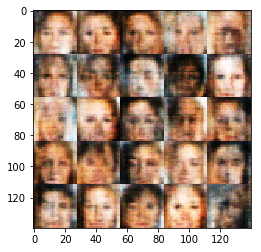

Epoch 0/1... Step: 910... Discriminator Loss: 1.5781... Generator Loss: 0.9662
Epoch 0/1... Step: 920... Discriminator Loss: 1.6994... Generator Loss: 1.0218
Epoch 0/1... Step: 930... Discriminator Loss: 1.5441... Generator Loss: 0.9153
Epoch 0/1... Step: 940... Discriminator Loss: 1.7137... Generator Loss: 1.4869
Epoch 0/1... Step: 950... Discriminator Loss: 2.0639... Generator Loss: 0.8030
Epoch 0/1... Step: 960... Discriminator Loss: 1.4968... Generator Loss: 1.0523
Epoch 0/1... Step: 970... Discriminator Loss: 1.5534... Generator Loss: 0.9926
Epoch 0/1... Step: 980... Discriminator Loss: 1.3110... Generator Loss: 1.1028
Epoch 0/1... Step: 990... Discriminator Loss: 1.4280... Generator Loss: 0.7747
Epoch 0/1... Step: 1000... Discriminator Loss: 1.2915... Generator Loss: 1.1061


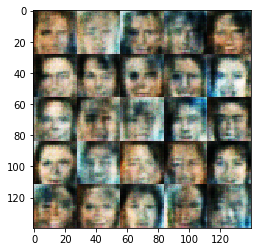

Epoch 0/1... Step: 1010... Discriminator Loss: 1.7846... Generator Loss: 1.6148
Epoch 0/1... Step: 1020... Discriminator Loss: 1.5812... Generator Loss: 0.8349
Epoch 0/1... Step: 1030... Discriminator Loss: 1.6561... Generator Loss: 0.7580
Epoch 0/1... Step: 1040... Discriminator Loss: 1.4404... Generator Loss: 0.6835
Epoch 0/1... Step: 1050... Discriminator Loss: 1.6508... Generator Loss: 0.8824
Epoch 0/1... Step: 1060... Discriminator Loss: 1.5339... Generator Loss: 1.2344
Epoch 0/1... Step: 1070... Discriminator Loss: 1.4880... Generator Loss: 0.7284
Epoch 0/1... Step: 1080... Discriminator Loss: 1.3608... Generator Loss: 0.7816
Epoch 0/1... Step: 1090... Discriminator Loss: 1.3943... Generator Loss: 0.8461
Epoch 0/1... Step: 1100... Discriminator Loss: 1.4101... Generator Loss: 0.9357


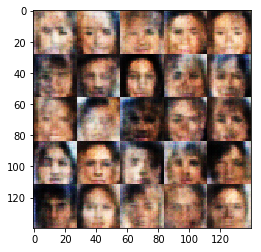

Epoch 0/1... Step: 1110... Discriminator Loss: 1.5198... Generator Loss: 1.3202
Epoch 0/1... Step: 1120... Discriminator Loss: 1.3717... Generator Loss: 0.7412
Epoch 0/1... Step: 1130... Discriminator Loss: 1.3467... Generator Loss: 1.4744
Epoch 0/1... Step: 1140... Discriminator Loss: 1.4610... Generator Loss: 0.7084
Epoch 0/1... Step: 1150... Discriminator Loss: 1.2690... Generator Loss: 0.8758
Epoch 0/1... Step: 1160... Discriminator Loss: 1.6742... Generator Loss: 1.6189
Epoch 0/1... Step: 1170... Discriminator Loss: 1.5774... Generator Loss: 0.7429
Epoch 0/1... Step: 1180... Discriminator Loss: 1.4457... Generator Loss: 1.0115
Epoch 0/1... Step: 1190... Discriminator Loss: 1.2928... Generator Loss: 0.9133
Epoch 0/1... Step: 1200... Discriminator Loss: 1.3635... Generator Loss: 1.1512


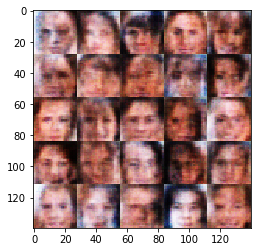

Epoch 0/1... Step: 1210... Discriminator Loss: 1.5856... Generator Loss: 0.8718
Epoch 0/1... Step: 1220... Discriminator Loss: 1.5297... Generator Loss: 0.7465
Epoch 0/1... Step: 1230... Discriminator Loss: 1.3224... Generator Loss: 0.9839
Epoch 0/1... Step: 1240... Discriminator Loss: 1.4977... Generator Loss: 0.7582
Epoch 0/1... Step: 1250... Discriminator Loss: 1.3486... Generator Loss: 0.7720
Epoch 0/1... Step: 1260... Discriminator Loss: 1.2759... Generator Loss: 0.9735
Epoch 0/1... Step: 1270... Discriminator Loss: 1.3303... Generator Loss: 0.9010
Epoch 0/1... Step: 1280... Discriminator Loss: 1.4315... Generator Loss: 0.8187
Epoch 0/1... Step: 1290... Discriminator Loss: 1.3589... Generator Loss: 0.7357
Epoch 0/1... Step: 1300... Discriminator Loss: 1.4379... Generator Loss: 0.6620


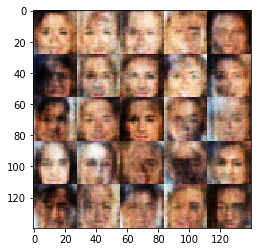

Epoch 0/1... Step: 1310... Discriminator Loss: 1.5198... Generator Loss: 0.7514
Epoch 0/1... Step: 1320... Discriminator Loss: 1.3811... Generator Loss: 0.7338
Epoch 0/1... Step: 1330... Discriminator Loss: 1.3974... Generator Loss: 0.8303
Epoch 0/1... Step: 1340... Discriminator Loss: 1.6608... Generator Loss: 0.7138
Epoch 0/1... Step: 1350... Discriminator Loss: 1.5876... Generator Loss: 0.9876
Epoch 0/1... Step: 1360... Discriminator Loss: 1.2903... Generator Loss: 0.8597
Epoch 0/1... Step: 1370... Discriminator Loss: 1.4753... Generator Loss: 1.1037
Epoch 0/1... Step: 1380... Discriminator Loss: 1.4066... Generator Loss: 0.7213
Epoch 0/1... Step: 1390... Discriminator Loss: 1.3990... Generator Loss: 1.1583
Epoch 0/1... Step: 1400... Discriminator Loss: 1.5129... Generator Loss: 0.7372


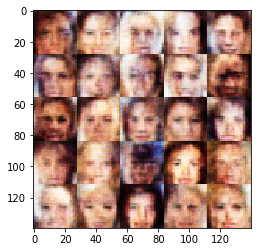

Epoch 0/1... Step: 1410... Discriminator Loss: 1.4133... Generator Loss: 0.7832
Epoch 0/1... Step: 1420... Discriminator Loss: 1.4934... Generator Loss: 0.6000
Epoch 0/1... Step: 1430... Discriminator Loss: 1.4481... Generator Loss: 0.6364
Epoch 0/1... Step: 1440... Discriminator Loss: 1.6127... Generator Loss: 0.7326
Epoch 0/1... Step: 1450... Discriminator Loss: 1.5906... Generator Loss: 0.6346
Epoch 0/1... Step: 1460... Discriminator Loss: 1.5432... Generator Loss: 1.2817
Epoch 0/1... Step: 1470... Discriminator Loss: 1.5161... Generator Loss: 0.8597
Epoch 0/1... Step: 1480... Discriminator Loss: 1.5964... Generator Loss: 0.7751
Epoch 0/1... Step: 1490... Discriminator Loss: 1.3563... Generator Loss: 0.8102
Epoch 0/1... Step: 1500... Discriminator Loss: 1.2968... Generator Loss: 1.0318


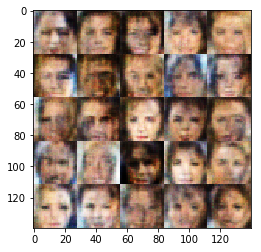

Epoch 0/1... Step: 1510... Discriminator Loss: 1.5218... Generator Loss: 0.8470
Epoch 0/1... Step: 1520... Discriminator Loss: 1.2971... Generator Loss: 0.7400
Epoch 0/1... Step: 1530... Discriminator Loss: 1.5770... Generator Loss: 0.9408
Epoch 0/1... Step: 1540... Discriminator Loss: 1.4134... Generator Loss: 0.7043
Epoch 0/1... Step: 1550... Discriminator Loss: 1.6937... Generator Loss: 0.7402
Epoch 0/1... Step: 1560... Discriminator Loss: 1.4649... Generator Loss: 0.8195
Epoch 0/1... Step: 1570... Discriminator Loss: 1.4168... Generator Loss: 0.7932
Epoch 0/1... Step: 1580... Discriminator Loss: 1.5047... Generator Loss: 0.6827
Epoch 0/1... Step: 1590... Discriminator Loss: 1.4932... Generator Loss: 1.0980
Epoch 0/1... Step: 1600... Discriminator Loss: 1.6275... Generator Loss: 0.7004


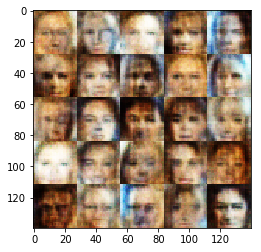

Epoch 0/1... Step: 1610... Discriminator Loss: 1.3843... Generator Loss: 0.8817
Epoch 0/1... Step: 1620... Discriminator Loss: 1.4138... Generator Loss: 0.6071
Epoch 0/1... Step: 1630... Discriminator Loss: 1.4769... Generator Loss: 1.0049
Epoch 0/1... Step: 1640... Discriminator Loss: 1.2803... Generator Loss: 1.0791
Epoch 0/1... Step: 1650... Discriminator Loss: 1.5477... Generator Loss: 0.6580
Epoch 0/1... Step: 1660... Discriminator Loss: 1.4154... Generator Loss: 0.7607
Epoch 0/1... Step: 1670... Discriminator Loss: 1.4140... Generator Loss: 0.9272
Epoch 0/1... Step: 1680... Discriminator Loss: 1.5219... Generator Loss: 1.5227
Epoch 0/1... Step: 1690... Discriminator Loss: 1.4295... Generator Loss: 0.8160
Epoch 0/1... Step: 1700... Discriminator Loss: 1.3871... Generator Loss: 0.7290


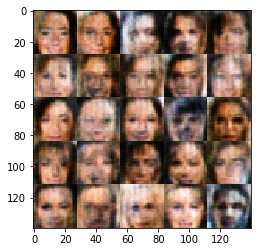

Epoch 0/1... Step: 1710... Discriminator Loss: 1.3843... Generator Loss: 0.8246
Epoch 0/1... Step: 1720... Discriminator Loss: 1.3111... Generator Loss: 0.7381
Epoch 0/1... Step: 1730... Discriminator Loss: 1.3927... Generator Loss: 0.8260
Epoch 0/1... Step: 1740... Discriminator Loss: 1.3303... Generator Loss: 1.0325
Epoch 0/1... Step: 1750... Discriminator Loss: 1.3242... Generator Loss: 0.9641
Epoch 0/1... Step: 1760... Discriminator Loss: 1.6541... Generator Loss: 1.0804
Epoch 0/1... Step: 1770... Discriminator Loss: 1.5283... Generator Loss: 1.0627
Epoch 0/1... Step: 1780... Discriminator Loss: 1.4958... Generator Loss: 0.6924
Epoch 0/1... Step: 1790... Discriminator Loss: 1.4267... Generator Loss: 0.7403
Epoch 0/1... Step: 1800... Discriminator Loss: 1.4801... Generator Loss: 0.9559


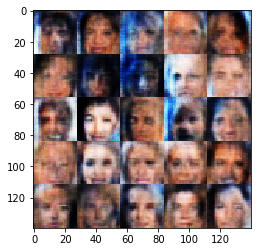

Epoch 0/1... Step: 1810... Discriminator Loss: 1.3102... Generator Loss: 0.8400
Epoch 0/1... Step: 1820... Discriminator Loss: 1.3791... Generator Loss: 0.7244
Epoch 0/1... Step: 1830... Discriminator Loss: 1.6366... Generator Loss: 0.9982
Epoch 0/1... Step: 1840... Discriminator Loss: 1.4182... Generator Loss: 0.6903
Epoch 0/1... Step: 1850... Discriminator Loss: 1.3445... Generator Loss: 0.8017
Epoch 0/1... Step: 1860... Discriminator Loss: 1.5048... Generator Loss: 0.8235
Epoch 0/1... Step: 1870... Discriminator Loss: 1.4185... Generator Loss: 0.9580
Epoch 0/1... Step: 1880... Discriminator Loss: 1.4401... Generator Loss: 0.8951
Epoch 0/1... Step: 1890... Discriminator Loss: 1.4902... Generator Loss: 0.6504
Epoch 0/1... Step: 1900... Discriminator Loss: 1.4516... Generator Loss: 0.9728


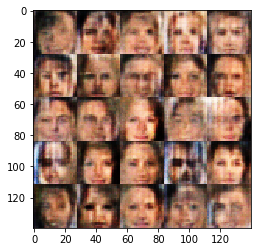

Epoch 0/1... Step: 1910... Discriminator Loss: 1.6615... Generator Loss: 0.6671
Epoch 0/1... Step: 1920... Discriminator Loss: 1.4232... Generator Loss: 0.6654
Epoch 0/1... Step: 1930... Discriminator Loss: 1.3557... Generator Loss: 0.7149
Epoch 0/1... Step: 1940... Discriminator Loss: 1.4924... Generator Loss: 0.6691
Epoch 0/1... Step: 1950... Discriminator Loss: 1.4355... Generator Loss: 1.0077
Epoch 0/1... Step: 1960... Discriminator Loss: 1.4150... Generator Loss: 0.6496
Epoch 0/1... Step: 1970... Discriminator Loss: 1.4109... Generator Loss: 0.8535
Epoch 0/1... Step: 1980... Discriminator Loss: 1.5418... Generator Loss: 0.6863
Epoch 0/1... Step: 1990... Discriminator Loss: 1.4980... Generator Loss: 0.8589
Epoch 0/1... Step: 2000... Discriminator Loss: 1.4171... Generator Loss: 0.7979


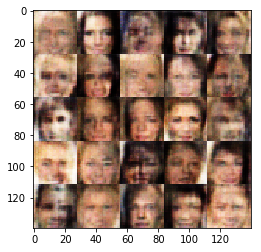

Epoch 0/1... Step: 2010... Discriminator Loss: 1.4558... Generator Loss: 0.6498
Epoch 0/1... Step: 2020... Discriminator Loss: 1.2957... Generator Loss: 0.6833
Epoch 0/1... Step: 2030... Discriminator Loss: 1.4075... Generator Loss: 0.7007
Epoch 0/1... Step: 2040... Discriminator Loss: 1.4399... Generator Loss: 0.6931
Epoch 0/1... Step: 2050... Discriminator Loss: 1.3644... Generator Loss: 0.7178
Epoch 0/1... Step: 2060... Discriminator Loss: 1.3751... Generator Loss: 0.6912
Epoch 0/1... Step: 2070... Discriminator Loss: 1.3325... Generator Loss: 0.7327
Epoch 0/1... Step: 2080... Discriminator Loss: 1.3876... Generator Loss: 0.7473
Epoch 0/1... Step: 2090... Discriminator Loss: 1.4286... Generator Loss: 0.8948
Epoch 0/1... Step: 2100... Discriminator Loss: 1.4920... Generator Loss: 0.6751


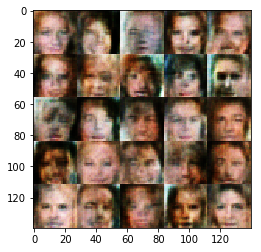

Epoch 0/1... Step: 2110... Discriminator Loss: 1.4194... Generator Loss: 0.7083
Epoch 0/1... Step: 2120... Discriminator Loss: 1.4470... Generator Loss: 0.7189
Epoch 0/1... Step: 2130... Discriminator Loss: 1.5308... Generator Loss: 0.8209
Epoch 0/1... Step: 2140... Discriminator Loss: 1.5930... Generator Loss: 0.7279
Epoch 0/1... Step: 2150... Discriminator Loss: 1.4769... Generator Loss: 0.6429
Epoch 0/1... Step: 2160... Discriminator Loss: 1.4842... Generator Loss: 0.6779
Epoch 0/1... Step: 2170... Discriminator Loss: 1.3220... Generator Loss: 0.7112
Epoch 0/1... Step: 2180... Discriminator Loss: 1.3490... Generator Loss: 0.6835
Epoch 0/1... Step: 2190... Discriminator Loss: 1.3223... Generator Loss: 0.7646
Epoch 0/1... Step: 2200... Discriminator Loss: 1.4856... Generator Loss: 0.6277


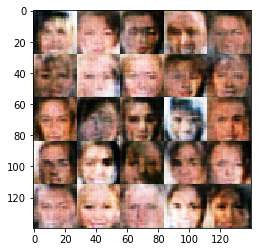

Epoch 0/1... Step: 2210... Discriminator Loss: 1.5034... Generator Loss: 0.7857
Epoch 0/1... Step: 2220... Discriminator Loss: 1.4155... Generator Loss: 0.7092
Epoch 0/1... Step: 2230... Discriminator Loss: 1.5143... Generator Loss: 0.7248
Epoch 0/1... Step: 2240... Discriminator Loss: 1.4335... Generator Loss: 0.6927
Epoch 0/1... Step: 2250... Discriminator Loss: 1.3752... Generator Loss: 0.7413
Epoch 0/1... Step: 2260... Discriminator Loss: 1.3990... Generator Loss: 0.6723
Epoch 0/1... Step: 2270... Discriminator Loss: 1.3836... Generator Loss: 0.6981
Epoch 0/1... Step: 2280... Discriminator Loss: 1.4504... Generator Loss: 0.6740
Epoch 0/1... Step: 2290... Discriminator Loss: 1.3863... Generator Loss: 0.7555
Epoch 0/1... Step: 2300... Discriminator Loss: 1.4395... Generator Loss: 0.7208


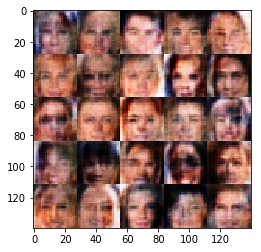

Epoch 0/1... Step: 2310... Discriminator Loss: 1.4412... Generator Loss: 0.8241
Epoch 0/1... Step: 2320... Discriminator Loss: 1.3144... Generator Loss: 0.8727
Epoch 0/1... Step: 2330... Discriminator Loss: 1.4067... Generator Loss: 0.7298
Epoch 0/1... Step: 2340... Discriminator Loss: 1.4863... Generator Loss: 0.6502
Epoch 0/1... Step: 2350... Discriminator Loss: 1.3573... Generator Loss: 0.6674
Epoch 0/1... Step: 2360... Discriminator Loss: 1.2334... Generator Loss: 0.6586
Epoch 0/1... Step: 2370... Discriminator Loss: 1.4189... Generator Loss: 0.7782
Epoch 0/1... Step: 2380... Discriminator Loss: 1.5059... Generator Loss: 0.8345
Epoch 0/1... Step: 2390... Discriminator Loss: 1.3072... Generator Loss: 0.8479
Epoch 0/1... Step: 2400... Discriminator Loss: 1.3971... Generator Loss: 0.7213


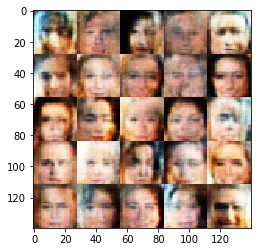

Epoch 0/1... Step: 2410... Discriminator Loss: 1.2945... Generator Loss: 1.0093
Epoch 0/1... Step: 2420... Discriminator Loss: 1.4859... Generator Loss: 0.7307
Epoch 0/1... Step: 2430... Discriminator Loss: 1.3395... Generator Loss: 0.7332
Epoch 0/1... Step: 2440... Discriminator Loss: 1.4409... Generator Loss: 0.7051
Epoch 0/1... Step: 2450... Discriminator Loss: 1.4151... Generator Loss: 0.7135
Epoch 0/1... Step: 2460... Discriminator Loss: 1.6316... Generator Loss: 0.6480
Epoch 0/1... Step: 2470... Discriminator Loss: 1.4065... Generator Loss: 0.6932
Epoch 0/1... Step: 2480... Discriminator Loss: 1.3638... Generator Loss: 0.7436
Epoch 0/1... Step: 2490... Discriminator Loss: 1.4066... Generator Loss: 0.8380
Epoch 0/1... Step: 2500... Discriminator Loss: 1.3539... Generator Loss: 1.0224


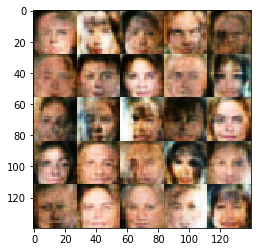

Epoch 0/1... Step: 2510... Discriminator Loss: 1.4701... Generator Loss: 0.9376
Epoch 0/1... Step: 2520... Discriminator Loss: 1.4309... Generator Loss: 0.7809
Epoch 0/1... Step: 2530... Discriminator Loss: 1.6804... Generator Loss: 0.6987
Epoch 0/1... Step: 2540... Discriminator Loss: 1.4931... Generator Loss: 0.6952
Epoch 0/1... Step: 2550... Discriminator Loss: 1.4231... Generator Loss: 0.8736
Epoch 0/1... Step: 2560... Discriminator Loss: 1.3825... Generator Loss: 0.7566
Epoch 0/1... Step: 2570... Discriminator Loss: 1.3750... Generator Loss: 0.8608
Epoch 0/1... Step: 2580... Discriminator Loss: 1.3575... Generator Loss: 0.7948
Epoch 0/1... Step: 2590... Discriminator Loss: 1.3825... Generator Loss: 0.7326
Epoch 0/1... Step: 2600... Discriminator Loss: 1.5271... Generator Loss: 0.8740


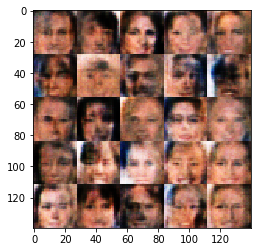

Epoch 0/1... Step: 2610... Discriminator Loss: 1.4288... Generator Loss: 0.6797
Epoch 0/1... Step: 2620... Discriminator Loss: 1.3923... Generator Loss: 0.7554
Epoch 0/1... Step: 2630... Discriminator Loss: 1.3743... Generator Loss: 0.7594
Epoch 0/1... Step: 2640... Discriminator Loss: 1.4171... Generator Loss: 0.6753
Epoch 0/1... Step: 2650... Discriminator Loss: 1.4068... Generator Loss: 0.6672
Epoch 0/1... Step: 2660... Discriminator Loss: 1.3442... Generator Loss: 0.7842
Epoch 0/1... Step: 2670... Discriminator Loss: 1.4481... Generator Loss: 0.6597
Epoch 0/1... Step: 2680... Discriminator Loss: 1.4160... Generator Loss: 0.7003
Epoch 0/1... Step: 2690... Discriminator Loss: 1.4274... Generator Loss: 0.6795
Epoch 0/1... Step: 2700... Discriminator Loss: 1.4053... Generator Loss: 0.7181


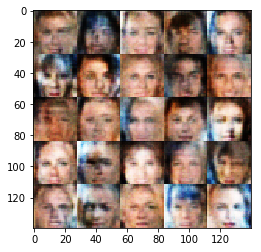

Epoch 0/1... Step: 2710... Discriminator Loss: 1.4301... Generator Loss: 0.7830
Epoch 0/1... Step: 2720... Discriminator Loss: 1.6856... Generator Loss: 0.7055
Epoch 0/1... Step: 2730... Discriminator Loss: 1.4240... Generator Loss: 0.6929
Epoch 0/1... Step: 2740... Discriminator Loss: 1.3336... Generator Loss: 0.7979
Epoch 0/1... Step: 2750... Discriminator Loss: 1.4151... Generator Loss: 0.8057
Epoch 0/1... Step: 2760... Discriminator Loss: 1.3931... Generator Loss: 0.7613
Epoch 0/1... Step: 2770... Discriminator Loss: 1.3629... Generator Loss: 0.7848
Epoch 0/1... Step: 2780... Discriminator Loss: 1.3633... Generator Loss: 0.7928
Epoch 0/1... Step: 2790... Discriminator Loss: 1.3826... Generator Loss: 0.8567
Epoch 0/1... Step: 2800... Discriminator Loss: 1.3938... Generator Loss: 0.8092


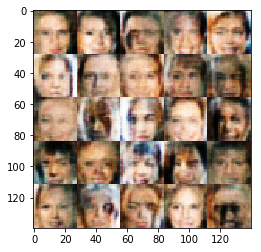

Epoch 0/1... Step: 2810... Discriminator Loss: 1.4677... Generator Loss: 0.8879
Epoch 0/1... Step: 2820... Discriminator Loss: 1.4384... Generator Loss: 0.5890
Epoch 0/1... Step: 2830... Discriminator Loss: 1.5008... Generator Loss: 0.6799
Epoch 0/1... Step: 2840... Discriminator Loss: 1.4049... Generator Loss: 0.9034
Epoch 0/1... Step: 2850... Discriminator Loss: 1.3646... Generator Loss: 0.7712
Epoch 0/1... Step: 2860... Discriminator Loss: 1.4054... Generator Loss: 0.7542
Epoch 0/1... Step: 2870... Discriminator Loss: 1.3170... Generator Loss: 0.6914
Epoch 0/1... Step: 2880... Discriminator Loss: 1.3271... Generator Loss: 0.7285
Epoch 0/1... Step: 2890... Discriminator Loss: 1.3827... Generator Loss: 0.7583
Epoch 0/1... Step: 2900... Discriminator Loss: 1.4720... Generator Loss: 0.6493


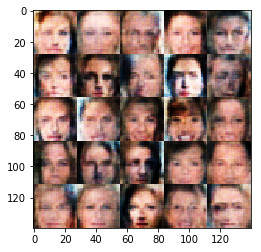

Epoch 0/1... Step: 2910... Discriminator Loss: 1.4071... Generator Loss: 0.7110
Epoch 0/1... Step: 2920... Discriminator Loss: 1.3314... Generator Loss: 0.6933
Epoch 0/1... Step: 2930... Discriminator Loss: 1.4454... Generator Loss: 0.6914
Epoch 0/1... Step: 2940... Discriminator Loss: 1.4860... Generator Loss: 0.7892
Epoch 0/1... Step: 2950... Discriminator Loss: 1.4408... Generator Loss: 0.8442
Epoch 0/1... Step: 2960... Discriminator Loss: 1.4607... Generator Loss: 0.8361
Epoch 0/1... Step: 2970... Discriminator Loss: 1.4065... Generator Loss: 0.8359
Epoch 0/1... Step: 2980... Discriminator Loss: 1.4148... Generator Loss: 0.7213
Epoch 0/1... Step: 2990... Discriminator Loss: 1.3870... Generator Loss: 0.8960
Epoch 0/1... Step: 3000... Discriminator Loss: 1.5091... Generator Loss: 0.7520


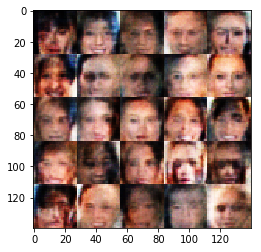

Epoch 0/1... Step: 3010... Discriminator Loss: 1.2987... Generator Loss: 0.7780
Epoch 0/1... Step: 3020... Discriminator Loss: 1.3680... Generator Loss: 0.7143
Epoch 0/1... Step: 3030... Discriminator Loss: 1.5283... Generator Loss: 0.6688
Epoch 0/1... Step: 3040... Discriminator Loss: 1.3626... Generator Loss: 0.8409
Epoch 0/1... Step: 3050... Discriminator Loss: 1.5423... Generator Loss: 0.7328
Epoch 0/1... Step: 3060... Discriminator Loss: 1.3023... Generator Loss: 1.0087
Epoch 0/1... Step: 3070... Discriminator Loss: 1.4948... Generator Loss: 0.9813
Epoch 0/1... Step: 3080... Discriminator Loss: 1.3914... Generator Loss: 0.7660
Epoch 0/1... Step: 3090... Discriminator Loss: 1.4130... Generator Loss: 0.8201
Epoch 0/1... Step: 3100... Discriminator Loss: 1.4093... Generator Loss: 0.6718


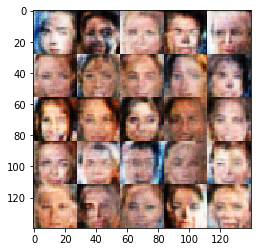

Epoch 0/1... Step: 3110... Discriminator Loss: 1.4941... Generator Loss: 0.7507
Epoch 0/1... Step: 3120... Discriminator Loss: 1.3976... Generator Loss: 0.7767
Epoch 0/1... Step: 3130... Discriminator Loss: 1.3872... Generator Loss: 0.7364
Epoch 0/1... Step: 3140... Discriminator Loss: 1.3688... Generator Loss: 0.7271
Epoch 0/1... Step: 3150... Discriminator Loss: 1.3884... Generator Loss: 0.8135
Epoch 0/1... Step: 3160... Discriminator Loss: 1.3616... Generator Loss: 0.7976
Epoch 0/1... Step: 3170... Discriminator Loss: 1.3614... Generator Loss: 0.6944
Epoch 0/1... Step: 3180... Discriminator Loss: 1.4558... Generator Loss: 0.7303
Epoch 0/1... Step: 3190... Discriminator Loss: 1.2910... Generator Loss: 0.8149
Epoch 0/1... Step: 3200... Discriminator Loss: 1.4494... Generator Loss: 0.7385


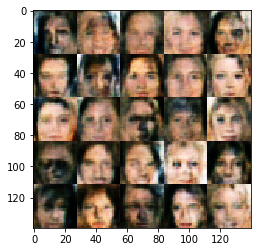

Epoch 0/1... Step: 3210... Discriminator Loss: 1.4150... Generator Loss: 0.6680
Epoch 0/1... Step: 3220... Discriminator Loss: 1.3455... Generator Loss: 0.6977
Epoch 0/1... Step: 3230... Discriminator Loss: 1.4007... Generator Loss: 0.6654
Epoch 0/1... Step: 3240... Discriminator Loss: 1.3350... Generator Loss: 0.7110
Epoch 0/1... Step: 3250... Discriminator Loss: 1.4726... Generator Loss: 0.9672
Epoch 0/1... Step: 3260... Discriminator Loss: 1.2818... Generator Loss: 0.8625
Epoch 0/1... Step: 3270... Discriminator Loss: 1.4933... Generator Loss: 0.8679
Epoch 0/1... Step: 3280... Discriminator Loss: 1.3697... Generator Loss: 0.7620
Epoch 0/1... Step: 3290... Discriminator Loss: 1.3394... Generator Loss: 0.6583
Epoch 0/1... Step: 3300... Discriminator Loss: 1.3538... Generator Loss: 0.7300


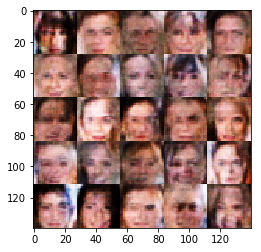

Epoch 0/1... Step: 3310... Discriminator Loss: 1.4941... Generator Loss: 0.7244
Epoch 0/1... Step: 3320... Discriminator Loss: 1.3309... Generator Loss: 0.7786
Epoch 0/1... Step: 3330... Discriminator Loss: 1.3241... Generator Loss: 0.6775
Epoch 0/1... Step: 3340... Discriminator Loss: 1.3898... Generator Loss: 0.6784
Epoch 0/1... Step: 3350... Discriminator Loss: 1.4445... Generator Loss: 0.6937
Epoch 0/1... Step: 3360... Discriminator Loss: 1.4351... Generator Loss: 0.7485
Epoch 0/1... Step: 3370... Discriminator Loss: 1.4011... Generator Loss: 0.7225
Epoch 0/1... Step: 3380... Discriminator Loss: 1.3937... Generator Loss: 0.7374
Epoch 0/1... Step: 3390... Discriminator Loss: 1.4636... Generator Loss: 0.6956
Epoch 0/1... Step: 3400... Discriminator Loss: 1.3974... Generator Loss: 0.6850


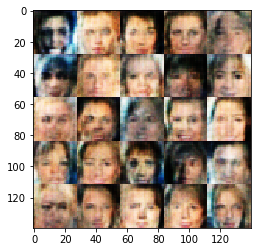

Epoch 0/1... Step: 3410... Discriminator Loss: 1.4569... Generator Loss: 0.8016
Epoch 0/1... Step: 3420... Discriminator Loss: 1.3666... Generator Loss: 0.6030
Epoch 0/1... Step: 3430... Discriminator Loss: 1.4649... Generator Loss: 0.7586
Epoch 0/1... Step: 3440... Discriminator Loss: 1.3891... Generator Loss: 0.7011
Epoch 0/1... Step: 3450... Discriminator Loss: 1.4109... Generator Loss: 0.7129
Epoch 0/1... Step: 3460... Discriminator Loss: 1.4007... Generator Loss: 0.7290
Epoch 0/1... Step: 3470... Discriminator Loss: 1.3682... Generator Loss: 0.7632
Epoch 0/1... Step: 3480... Discriminator Loss: 1.4168... Generator Loss: 0.6979
Epoch 0/1... Step: 3490... Discriminator Loss: 1.3589... Generator Loss: 0.7812
Epoch 0/1... Step: 3500... Discriminator Loss: 1.4365... Generator Loss: 0.7408


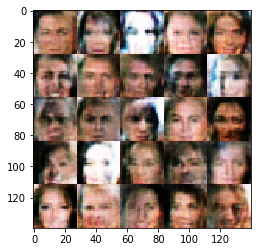

Epoch 0/1... Step: 3510... Discriminator Loss: 1.4190... Generator Loss: 0.6635
Epoch 0/1... Step: 3520... Discriminator Loss: 1.3918... Generator Loss: 0.7483
Epoch 0/1... Step: 3530... Discriminator Loss: 1.5000... Generator Loss: 0.6346
Epoch 0/1... Step: 3540... Discriminator Loss: 1.5246... Generator Loss: 0.6329
Epoch 0/1... Step: 3550... Discriminator Loss: 1.3729... Generator Loss: 0.7344
Epoch 0/1... Step: 3560... Discriminator Loss: 1.4881... Generator Loss: 0.8663
Epoch 0/1... Step: 3570... Discriminator Loss: 1.3618... Generator Loss: 0.8089
Epoch 0/1... Step: 3580... Discriminator Loss: 1.5333... Generator Loss: 0.5964
Epoch 0/1... Step: 3590... Discriminator Loss: 1.4206... Generator Loss: 0.6688
Epoch 0/1... Step: 3600... Discriminator Loss: 1.4167... Generator Loss: 0.7000


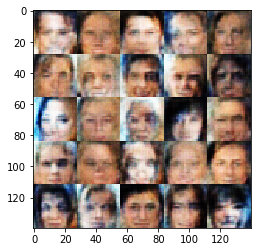

Epoch 0/1... Step: 3610... Discriminator Loss: 1.4717... Generator Loss: 0.6734
Epoch 0/1... Step: 3620... Discriminator Loss: 1.4079... Generator Loss: 0.7658
Epoch 0/1... Step: 3630... Discriminator Loss: 1.3202... Generator Loss: 0.6840
Epoch 0/1... Step: 3640... Discriminator Loss: 1.4400... Generator Loss: 0.6767
Epoch 0/1... Step: 3650... Discriminator Loss: 1.5084... Generator Loss: 0.7624
Epoch 0/1... Step: 3660... Discriminator Loss: 1.4146... Generator Loss: 0.6584
Epoch 0/1... Step: 3670... Discriminator Loss: 1.4098... Generator Loss: 0.7722
Epoch 0/1... Step: 3680... Discriminator Loss: 1.3553... Generator Loss: 0.6788
Epoch 0/1... Step: 3690... Discriminator Loss: 1.4473... Generator Loss: 0.5986
Epoch 0/1... Step: 3700... Discriminator Loss: 1.4751... Generator Loss: 0.7433


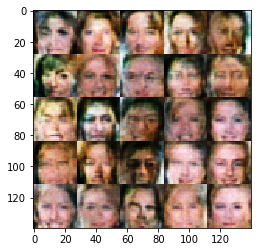

Epoch 0/1... Step: 3710... Discriminator Loss: 1.3267... Generator Loss: 0.6564
Epoch 0/1... Step: 3720... Discriminator Loss: 1.3626... Generator Loss: 0.6959
Epoch 0/1... Step: 3730... Discriminator Loss: 1.3827... Generator Loss: 0.7716
Epoch 0/1... Step: 3740... Discriminator Loss: 1.4549... Generator Loss: 0.6794
Epoch 0/1... Step: 3750... Discriminator Loss: 1.3354... Generator Loss: 0.8126
Epoch 0/1... Step: 3760... Discriminator Loss: 1.3613... Generator Loss: 0.7295
Epoch 0/1... Step: 3770... Discriminator Loss: 1.4331... Generator Loss: 0.7381
Epoch 0/1... Step: 3780... Discriminator Loss: 1.3954... Generator Loss: 0.6966
Epoch 0/1... Step: 3790... Discriminator Loss: 1.3990... Generator Loss: 0.8799
Epoch 0/1... Step: 3800... Discriminator Loss: 1.3305... Generator Loss: 0.7667


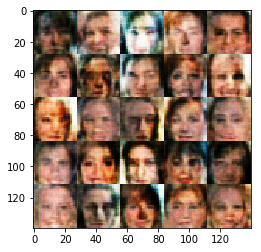

Epoch 0/1... Step: 3810... Discriminator Loss: 1.4060... Generator Loss: 0.6571
Epoch 0/1... Step: 3820... Discriminator Loss: 1.4759... Generator Loss: 0.8325
Epoch 0/1... Step: 3830... Discriminator Loss: 1.4579... Generator Loss: 0.9083
Epoch 0/1... Step: 3840... Discriminator Loss: 1.3847... Generator Loss: 0.7043
Epoch 0/1... Step: 3850... Discriminator Loss: 1.3853... Generator Loss: 0.8124
Epoch 0/1... Step: 3860... Discriminator Loss: 1.3683... Generator Loss: 0.7106
Epoch 0/1... Step: 3870... Discriminator Loss: 1.3669... Generator Loss: 0.7194
Epoch 0/1... Step: 3880... Discriminator Loss: 1.5406... Generator Loss: 0.5931
Epoch 0/1... Step: 3890... Discriminator Loss: 1.4286... Generator Loss: 0.6599
Epoch 0/1... Step: 3900... Discriminator Loss: 1.4503... Generator Loss: 0.9203


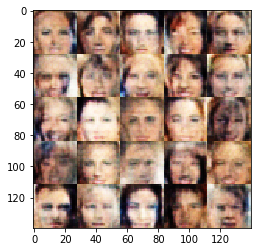

Epoch 0/1... Step: 3910... Discriminator Loss: 1.3894... Generator Loss: 0.6882
Epoch 0/1... Step: 3920... Discriminator Loss: 1.5190... Generator Loss: 0.7890
Epoch 0/1... Step: 3930... Discriminator Loss: 1.3757... Generator Loss: 0.6595
Epoch 0/1... Step: 3940... Discriminator Loss: 1.4644... Generator Loss: 0.7299
Epoch 0/1... Step: 3950... Discriminator Loss: 1.3909... Generator Loss: 0.6353
Epoch 0/1... Step: 3960... Discriminator Loss: 1.3516... Generator Loss: 0.7006
Epoch 0/1... Step: 3970... Discriminator Loss: 1.5124... Generator Loss: 0.7472
Epoch 0/1... Step: 3980... Discriminator Loss: 1.4015... Generator Loss: 0.6835
Epoch 0/1... Step: 3990... Discriminator Loss: 1.3702... Generator Loss: 0.7030
Epoch 0/1... Step: 4000... Discriminator Loss: 1.3690... Generator Loss: 0.7041


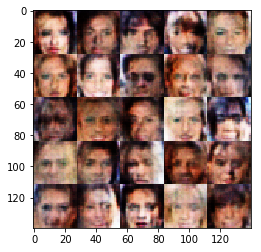

Epoch 0/1... Step: 4010... Discriminator Loss: 1.3908... Generator Loss: 0.7808
Epoch 0/1... Step: 4020... Discriminator Loss: 1.4204... Generator Loss: 0.7807
Epoch 0/1... Step: 4030... Discriminator Loss: 1.3803... Generator Loss: 0.6834
Epoch 0/1... Step: 4040... Discriminator Loss: 1.4437... Generator Loss: 0.7301
Epoch 0/1... Step: 4050... Discriminator Loss: 1.4256... Generator Loss: 0.7737
Epoch 0/1... Step: 4060... Discriminator Loss: 1.4830... Generator Loss: 0.6664
Epoch 0/1... Step: 4070... Discriminator Loss: 1.3876... Generator Loss: 0.7021
Epoch 0/1... Step: 4080... Discriminator Loss: 1.3413... Generator Loss: 0.6856
Epoch 0/1... Step: 4090... Discriminator Loss: 1.5687... Generator Loss: 0.8499
Epoch 0/1... Step: 4100... Discriminator Loss: 1.4513... Generator Loss: 0.9065


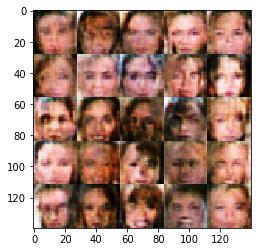

Epoch 0/1... Step: 4110... Discriminator Loss: 1.3712... Generator Loss: 0.7830
Epoch 0/1... Step: 4120... Discriminator Loss: 1.4213... Generator Loss: 0.6758
Epoch 0/1... Step: 4130... Discriminator Loss: 1.4146... Generator Loss: 0.7096
Epoch 0/1... Step: 4140... Discriminator Loss: 1.3914... Generator Loss: 0.7045
Epoch 0/1... Step: 4150... Discriminator Loss: 1.4680... Generator Loss: 0.7309
Epoch 0/1... Step: 4160... Discriminator Loss: 1.3565... Generator Loss: 0.8811
Epoch 0/1... Step: 4170... Discriminator Loss: 1.3931... Generator Loss: 0.7124
Epoch 0/1... Step: 4180... Discriminator Loss: 1.4104... Generator Loss: 0.6637
Epoch 0/1... Step: 4190... Discriminator Loss: 1.4111... Generator Loss: 0.7697
Epoch 0/1... Step: 4200... Discriminator Loss: 1.3462... Generator Loss: 0.7771


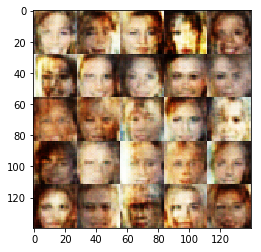

Epoch 0/1... Step: 4210... Discriminator Loss: 1.3977... Generator Loss: 0.7414
Epoch 0/1... Step: 4220... Discriminator Loss: 1.5145... Generator Loss: 0.6072
Epoch 0/1... Step: 4230... Discriminator Loss: 1.4184... Generator Loss: 0.9001
Epoch 0/1... Step: 4240... Discriminator Loss: 1.3823... Generator Loss: 0.6999
Epoch 0/1... Step: 4250... Discriminator Loss: 1.3359... Generator Loss: 0.6735
Epoch 0/1... Step: 4260... Discriminator Loss: 1.4504... Generator Loss: 0.6076
Epoch 0/1... Step: 4270... Discriminator Loss: 1.4121... Generator Loss: 0.7361
Epoch 0/1... Step: 4280... Discriminator Loss: 1.4283... Generator Loss: 0.9033
Epoch 0/1... Step: 4290... Discriminator Loss: 1.3766... Generator Loss: 0.7428
Epoch 0/1... Step: 4300... Discriminator Loss: 1.4507... Generator Loss: 0.7938


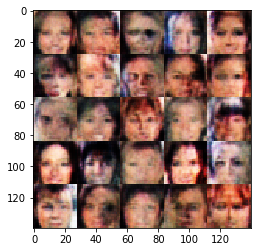

Epoch 0/1... Step: 4310... Discriminator Loss: 1.3294... Generator Loss: 0.6978
Epoch 0/1... Step: 4320... Discriminator Loss: 1.3712... Generator Loss: 0.6961
Epoch 0/1... Step: 4330... Discriminator Loss: 1.3854... Generator Loss: 0.6774
Epoch 0/1... Step: 4340... Discriminator Loss: 1.3873... Generator Loss: 0.9036
Epoch 0/1... Step: 4350... Discriminator Loss: 1.4743... Generator Loss: 0.6265
Epoch 0/1... Step: 4360... Discriminator Loss: 1.3346... Generator Loss: 0.8356
Epoch 0/1... Step: 4370... Discriminator Loss: 1.3661... Generator Loss: 0.7554
Epoch 0/1... Step: 4380... Discriminator Loss: 1.4539... Generator Loss: 0.5942
Epoch 0/1... Step: 4390... Discriminator Loss: 1.4157... Generator Loss: 0.8646
Epoch 0/1... Step: 4400... Discriminator Loss: 1.3435... Generator Loss: 0.9239


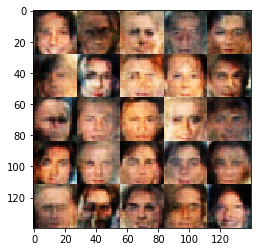

Epoch 0/1... Step: 4410... Discriminator Loss: 1.4254... Generator Loss: 0.8549
Epoch 0/1... Step: 4420... Discriminator Loss: 1.3755... Generator Loss: 0.7026
Epoch 0/1... Step: 4430... Discriminator Loss: 1.3976... Generator Loss: 0.7644
Epoch 0/1... Step: 4440... Discriminator Loss: 1.4511... Generator Loss: 0.6086
Epoch 0/1... Step: 4450... Discriminator Loss: 1.3890... Generator Loss: 0.6873
Epoch 0/1... Step: 4460... Discriminator Loss: 1.3768... Generator Loss: 0.6926
Epoch 0/1... Step: 4470... Discriminator Loss: 1.4383... Generator Loss: 0.7101
Epoch 0/1... Step: 4480... Discriminator Loss: 1.4556... Generator Loss: 0.8550
Epoch 0/1... Step: 4490... Discriminator Loss: 1.3672... Generator Loss: 0.8469
Epoch 0/1... Step: 4500... Discriminator Loss: 1.3456... Generator Loss: 0.8619


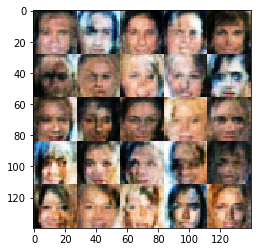

Epoch 0/1... Step: 4510... Discriminator Loss: 1.3486... Generator Loss: 0.7098
Epoch 0/1... Step: 4520... Discriminator Loss: 1.3586... Generator Loss: 0.6904
Epoch 0/1... Step: 4530... Discriminator Loss: 1.3951... Generator Loss: 0.7352
Epoch 0/1... Step: 4540... Discriminator Loss: 1.4123... Generator Loss: 0.7048
Epoch 0/1... Step: 4550... Discriminator Loss: 1.5018... Generator Loss: 0.5942
Epoch 0/1... Step: 4560... Discriminator Loss: 1.4661... Generator Loss: 0.6592
Epoch 0/1... Step: 4570... Discriminator Loss: 1.3767... Generator Loss: 0.6900
Epoch 0/1... Step: 4580... Discriminator Loss: 1.3805... Generator Loss: 0.7700
Epoch 0/1... Step: 4590... Discriminator Loss: 1.3789... Generator Loss: 0.6578
Epoch 0/1... Step: 4600... Discriminator Loss: 1.3853... Generator Loss: 0.8211


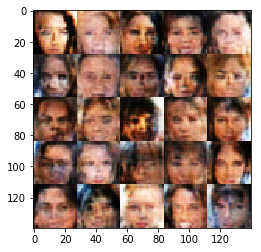

Epoch 0/1... Step: 4610... Discriminator Loss: 1.4388... Generator Loss: 0.6245
Epoch 0/1... Step: 4620... Discriminator Loss: 1.4449... Generator Loss: 0.6740
Epoch 0/1... Step: 4630... Discriminator Loss: 1.4641... Generator Loss: 0.8355
Epoch 0/1... Step: 4640... Discriminator Loss: 1.3760... Generator Loss: 0.7284
Epoch 0/1... Step: 4650... Discriminator Loss: 1.4258... Generator Loss: 0.6811
Epoch 0/1... Step: 4660... Discriminator Loss: 1.3656... Generator Loss: 0.7041
Epoch 0/1... Step: 4670... Discriminator Loss: 1.4851... Generator Loss: 0.6631
Epoch 0/1... Step: 4680... Discriminator Loss: 1.3573... Generator Loss: 0.6622
Epoch 0/1... Step: 4690... Discriminator Loss: 1.6840... Generator Loss: 0.6054
Epoch 0/1... Step: 4700... Discriminator Loss: 1.3619... Generator Loss: 0.6865


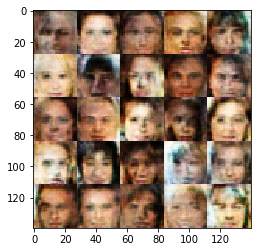

Epoch 0/1... Step: 4710... Discriminator Loss: 1.4658... Generator Loss: 0.6562
Epoch 0/1... Step: 4720... Discriminator Loss: 1.3951... Generator Loss: 0.7246
Epoch 0/1... Step: 4730... Discriminator Loss: 1.3500... Generator Loss: 0.6725
Epoch 0/1... Step: 4740... Discriminator Loss: 1.3821... Generator Loss: 0.6734
Epoch 0/1... Step: 4750... Discriminator Loss: 1.4505... Generator Loss: 0.7036
Epoch 0/1... Step: 4760... Discriminator Loss: 1.5237... Generator Loss: 0.6380
Epoch 0/1... Step: 4770... Discriminator Loss: 1.4336... Generator Loss: 0.6542
Epoch 0/1... Step: 4780... Discriminator Loss: 1.4099... Generator Loss: 0.7788
Epoch 0/1... Step: 4790... Discriminator Loss: 1.4009... Generator Loss: 0.7047
Epoch 0/1... Step: 4800... Discriminator Loss: 1.3188... Generator Loss: 0.8334


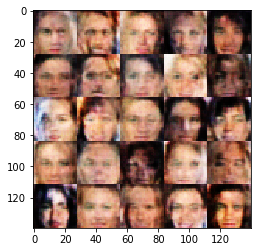

Epoch 0/1... Step: 4810... Discriminator Loss: 1.4479... Generator Loss: 0.6749
Epoch 0/1... Step: 4820... Discriminator Loss: 1.4228... Generator Loss: 0.6848
Epoch 0/1... Step: 4830... Discriminator Loss: 1.3753... Generator Loss: 0.6405
Epoch 0/1... Step: 4840... Discriminator Loss: 1.3542... Generator Loss: 0.7123
Epoch 0/1... Step: 4850... Discriminator Loss: 1.3379... Generator Loss: 0.8356
Epoch 0/1... Step: 4860... Discriminator Loss: 1.4170... Generator Loss: 0.7789
Epoch 0/1... Step: 4870... Discriminator Loss: 1.3747... Generator Loss: 0.7492
Epoch 0/1... Step: 4880... Discriminator Loss: 1.4256... Generator Loss: 0.8162
Epoch 0/1... Step: 4890... Discriminator Loss: 1.4762... Generator Loss: 0.8793
Epoch 0/1... Step: 4900... Discriminator Loss: 1.3968... Generator Loss: 0.7107


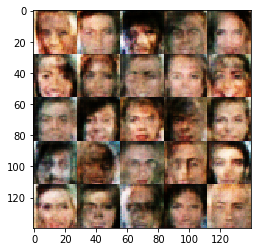

Epoch 0/1... Step: 4910... Discriminator Loss: 1.4782... Generator Loss: 0.9174
Epoch 0/1... Step: 4920... Discriminator Loss: 1.4852... Generator Loss: 0.5895
Epoch 0/1... Step: 4930... Discriminator Loss: 1.3918... Generator Loss: 0.7188
Epoch 0/1... Step: 4940... Discriminator Loss: 1.4303... Generator Loss: 0.7906
Epoch 0/1... Step: 4950... Discriminator Loss: 1.3783... Generator Loss: 0.6895
Epoch 0/1... Step: 4960... Discriminator Loss: 1.3826... Generator Loss: 0.7216
Epoch 0/1... Step: 4970... Discriminator Loss: 1.3825... Generator Loss: 0.7293
Epoch 0/1... Step: 4980... Discriminator Loss: 1.3465... Generator Loss: 0.7806
Epoch 0/1... Step: 4990... Discriminator Loss: 1.3361... Generator Loss: 0.7151
Epoch 0/1... Step: 5000... Discriminator Loss: 1.4145... Generator Loss: 0.8236


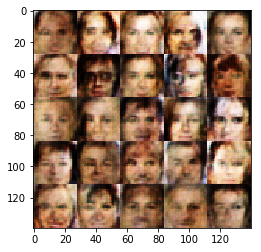

Epoch 0/1... Step: 5010... Discriminator Loss: 1.5298... Generator Loss: 0.6624
Epoch 0/1... Step: 5020... Discriminator Loss: 1.3718... Generator Loss: 0.8002
Epoch 0/1... Step: 5030... Discriminator Loss: 1.3883... Generator Loss: 0.6210
Epoch 0/1... Step: 5040... Discriminator Loss: 1.5750... Generator Loss: 1.0313
Epoch 0/1... Step: 5050... Discriminator Loss: 1.3589... Generator Loss: 0.6820
Epoch 0/1... Step: 5060... Discriminator Loss: 1.4173... Generator Loss: 0.6808
Epoch 0/1... Step: 5070... Discriminator Loss: 1.4176... Generator Loss: 0.7831
Epoch 0/1... Step: 5080... Discriminator Loss: 1.3650... Generator Loss: 0.7305
Epoch 0/1... Step: 5090... Discriminator Loss: 1.4936... Generator Loss: 0.6161
Epoch 0/1... Step: 5100... Discriminator Loss: 1.4532... Generator Loss: 0.7538


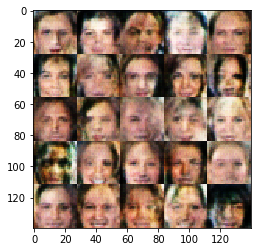

Epoch 0/1... Step: 5110... Discriminator Loss: 1.4775... Generator Loss: 0.7998
Epoch 0/1... Step: 5120... Discriminator Loss: 1.3743... Generator Loss: 0.7052
Epoch 0/1... Step: 5130... Discriminator Loss: 1.4203... Generator Loss: 0.6568
Epoch 0/1... Step: 5140... Discriminator Loss: 1.4245... Generator Loss: 0.7517
Epoch 0/1... Step: 5150... Discriminator Loss: 1.3491... Generator Loss: 0.7663
Epoch 0/1... Step: 5160... Discriminator Loss: 1.4077... Generator Loss: 0.8182
Epoch 0/1... Step: 5170... Discriminator Loss: 1.4514... Generator Loss: 0.7873
Epoch 0/1... Step: 5180... Discriminator Loss: 1.3946... Generator Loss: 0.7396
Epoch 0/1... Step: 5190... Discriminator Loss: 1.3915... Generator Loss: 0.7445
Epoch 0/1... Step: 5200... Discriminator Loss: 1.4332... Generator Loss: 0.7080


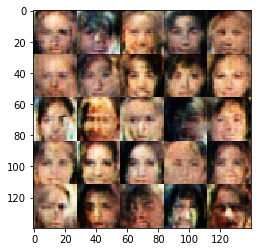

Epoch 0/1... Step: 5210... Discriminator Loss: 1.4059... Generator Loss: 0.7442
Epoch 0/1... Step: 5220... Discriminator Loss: 1.3675... Generator Loss: 0.7592
Epoch 0/1... Step: 5230... Discriminator Loss: 1.4209... Generator Loss: 0.8346
Epoch 0/1... Step: 5240... Discriminator Loss: 1.3721... Generator Loss: 0.7184
Epoch 0/1... Step: 5250... Discriminator Loss: 1.5015... Generator Loss: 0.6756
Epoch 0/1... Step: 5260... Discriminator Loss: 1.4178... Generator Loss: 0.6605
Epoch 0/1... Step: 5270... Discriminator Loss: 1.4550... Generator Loss: 0.8110
Epoch 0/1... Step: 5280... Discriminator Loss: 1.3945... Generator Loss: 0.7818
Epoch 0/1... Step: 5290... Discriminator Loss: 1.5411... Generator Loss: 0.6924
Epoch 0/1... Step: 5300... Discriminator Loss: 1.4080... Generator Loss: 0.6757


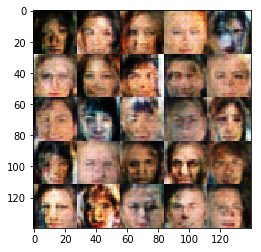

Epoch 0/1... Step: 5310... Discriminator Loss: 1.3684... Generator Loss: 0.7469
Epoch 0/1... Step: 5320... Discriminator Loss: 1.3631... Generator Loss: 0.6944
Epoch 0/1... Step: 5330... Discriminator Loss: 1.4496... Generator Loss: 0.6520
Epoch 0/1... Step: 5340... Discriminator Loss: 1.4248... Generator Loss: 0.6896
Epoch 0/1... Step: 5350... Discriminator Loss: 1.4165... Generator Loss: 0.5729
Epoch 0/1... Step: 5360... Discriminator Loss: 1.4082... Generator Loss: 0.7886
Epoch 0/1... Step: 5370... Discriminator Loss: 1.4162... Generator Loss: 0.7930
Epoch 0/1... Step: 5380... Discriminator Loss: 1.4618... Generator Loss: 0.6412
Epoch 0/1... Step: 5390... Discriminator Loss: 1.3751... Generator Loss: 0.8264
Epoch 0/1... Step: 5400... Discriminator Loss: 1.6383... Generator Loss: 0.9099


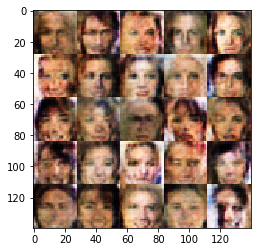

Epoch 0/1... Step: 5410... Discriminator Loss: 1.4033... Generator Loss: 0.6566
Epoch 0/1... Step: 5420... Discriminator Loss: 1.3808... Generator Loss: 0.7219
Epoch 0/1... Step: 5430... Discriminator Loss: 1.4341... Generator Loss: 0.6578
Epoch 0/1... Step: 5440... Discriminator Loss: 1.4071... Generator Loss: 0.7213
Epoch 0/1... Step: 5450... Discriminator Loss: 1.4530... Generator Loss: 0.7983
Epoch 0/1... Step: 5460... Discriminator Loss: 1.5389... Generator Loss: 0.7602
Epoch 0/1... Step: 5470... Discriminator Loss: 1.4056... Generator Loss: 0.8096
Epoch 0/1... Step: 5480... Discriminator Loss: 1.4309... Generator Loss: 0.7339
Epoch 0/1... Step: 5490... Discriminator Loss: 1.3800... Generator Loss: 0.7190
Epoch 0/1... Step: 5500... Discriminator Loss: 1.3621... Generator Loss: 0.7050


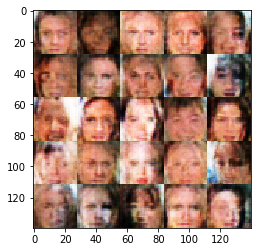

Epoch 0/1... Step: 5510... Discriminator Loss: 1.4381... Generator Loss: 0.8766
Epoch 0/1... Step: 5520... Discriminator Loss: 1.3656... Generator Loss: 0.7177
Epoch 0/1... Step: 5530... Discriminator Loss: 1.3234... Generator Loss: 0.6959
Epoch 0/1... Step: 5540... Discriminator Loss: 1.4041... Generator Loss: 0.8970
Epoch 0/1... Step: 5550... Discriminator Loss: 1.3622... Generator Loss: 0.7086
Epoch 0/1... Step: 5560... Discriminator Loss: 1.3218... Generator Loss: 0.7812
Epoch 0/1... Step: 5570... Discriminator Loss: 1.3924... Generator Loss: 0.6737
Epoch 0/1... Step: 5580... Discriminator Loss: 1.3844... Generator Loss: 0.7417
Epoch 0/1... Step: 5590... Discriminator Loss: 1.4501... Generator Loss: 0.7417
Epoch 0/1... Step: 5600... Discriminator Loss: 1.5080... Generator Loss: 0.6472


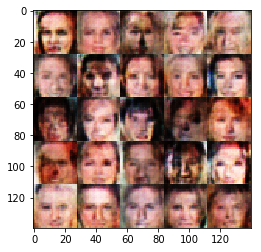

Epoch 0/1... Step: 5610... Discriminator Loss: 1.3688... Generator Loss: 0.9966
Epoch 0/1... Step: 5620... Discriminator Loss: 1.3534... Generator Loss: 0.6903
Epoch 0/1... Step: 5630... Discriminator Loss: 1.4070... Generator Loss: 0.7698
Epoch 0/1... Step: 5640... Discriminator Loss: 1.4319... Generator Loss: 0.7270
Epoch 0/1... Step: 5650... Discriminator Loss: 1.3713... Generator Loss: 0.7392
Epoch 0/1... Step: 5660... Discriminator Loss: 1.4112... Generator Loss: 0.7264
Epoch 0/1... Step: 5670... Discriminator Loss: 1.3871... Generator Loss: 0.7762
Epoch 0/1... Step: 5680... Discriminator Loss: 1.3752... Generator Loss: 0.6943
Epoch 0/1... Step: 5690... Discriminator Loss: 1.3835... Generator Loss: 0.7121
Epoch 0/1... Step: 5700... Discriminator Loss: 1.3411... Generator Loss: 0.7213


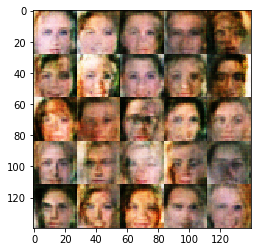

Epoch 0/1... Step: 5710... Discriminator Loss: 1.4260... Generator Loss: 0.7112
Epoch 0/1... Step: 5720... Discriminator Loss: 1.3832... Generator Loss: 0.8018
Epoch 0/1... Step: 5730... Discriminator Loss: 1.4027... Generator Loss: 0.7082
Epoch 0/1... Step: 5740... Discriminator Loss: 1.4200... Generator Loss: 0.7379
Epoch 0/1... Step: 5750... Discriminator Loss: 1.4312... Generator Loss: 0.7067
Epoch 0/1... Step: 5760... Discriminator Loss: 1.3610... Generator Loss: 0.6375
Epoch 0/1... Step: 5770... Discriminator Loss: 1.4440... Generator Loss: 0.6835
Epoch 0/1... Step: 5780... Discriminator Loss: 1.3779... Generator Loss: 0.7247
Epoch 0/1... Step: 5790... Discriminator Loss: 1.3985... Generator Loss: 0.7277
Epoch 0/1... Step: 5800... Discriminator Loss: 1.3521... Generator Loss: 0.8002


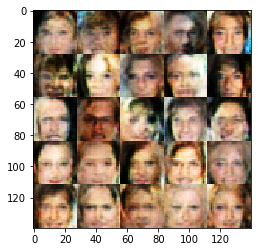

Epoch 0/1... Step: 5810... Discriminator Loss: 1.4059... Generator Loss: 0.7235
Epoch 0/1... Step: 5820... Discriminator Loss: 1.3915... Generator Loss: 0.9139
Epoch 0/1... Step: 5830... Discriminator Loss: 1.4775... Generator Loss: 0.7423
Epoch 0/1... Step: 5840... Discriminator Loss: 1.3264... Generator Loss: 0.8842
Epoch 0/1... Step: 5850... Discriminator Loss: 1.3207... Generator Loss: 1.0356
Epoch 0/1... Step: 5860... Discriminator Loss: 1.4072... Generator Loss: 0.8649
Epoch 0/1... Step: 5870... Discriminator Loss: 1.3727... Generator Loss: 0.7019
Epoch 0/1... Step: 5880... Discriminator Loss: 1.3407... Generator Loss: 0.7767
Epoch 0/1... Step: 5890... Discriminator Loss: 1.3904... Generator Loss: 0.7104
Epoch 0/1... Step: 5900... Discriminator Loss: 1.3232... Generator Loss: 0.8076


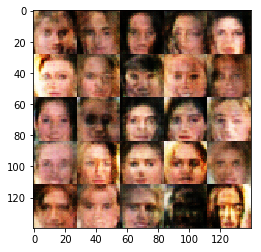

Epoch 0/1... Step: 5910... Discriminator Loss: 1.3381... Generator Loss: 0.8899
Epoch 0/1... Step: 5920... Discriminator Loss: 1.4299... Generator Loss: 0.6197
Epoch 0/1... Step: 5930... Discriminator Loss: 1.3562... Generator Loss: 0.5803
Epoch 0/1... Step: 5940... Discriminator Loss: 1.3902... Generator Loss: 0.7894
Epoch 0/1... Step: 5950... Discriminator Loss: 1.3868... Generator Loss: 0.7619
Epoch 0/1... Step: 5960... Discriminator Loss: 1.5532... Generator Loss: 0.7717
Epoch 0/1... Step: 5970... Discriminator Loss: 1.4069... Generator Loss: 0.7374
Epoch 0/1... Step: 5980... Discriminator Loss: 1.4084... Generator Loss: 0.7357
Epoch 0/1... Step: 5990... Discriminator Loss: 1.3434... Generator Loss: 0.7945
Epoch 0/1... Step: 6000... Discriminator Loss: 1.3699... Generator Loss: 0.7582


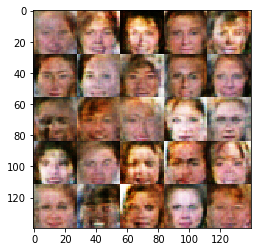

Epoch 0/1... Step: 6010... Discriminator Loss: 1.3414... Generator Loss: 0.7503
Epoch 0/1... Step: 6020... Discriminator Loss: 1.6442... Generator Loss: 0.5464
Epoch 0/1... Step: 6030... Discriminator Loss: 1.3397... Generator Loss: 0.6899
Epoch 0/1... Step: 6040... Discriminator Loss: 1.4493... Generator Loss: 0.6782
Epoch 0/1... Step: 6050... Discriminator Loss: 1.3733... Generator Loss: 0.6958
Epoch 0/1... Step: 6060... Discriminator Loss: 1.3906... Generator Loss: 0.6742
Epoch 0/1... Step: 6070... Discriminator Loss: 1.4307... Generator Loss: 0.9282
Epoch 0/1... Step: 6080... Discriminator Loss: 1.4276... Generator Loss: 0.7258
Epoch 0/1... Step: 6090... Discriminator Loss: 1.3763... Generator Loss: 0.8306
Epoch 0/1... Step: 6100... Discriminator Loss: 1.3772... Generator Loss: 0.6954


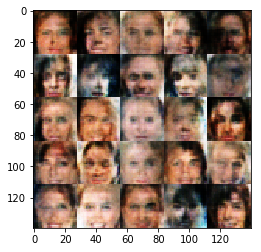

Epoch 0/1... Step: 6110... Discriminator Loss: 1.3868... Generator Loss: 0.6858
Epoch 0/1... Step: 6120... Discriminator Loss: 1.4027... Generator Loss: 0.6340
Epoch 0/1... Step: 6130... Discriminator Loss: 1.3973... Generator Loss: 0.6930
Epoch 0/1... Step: 6140... Discriminator Loss: 1.4995... Generator Loss: 0.8900
Epoch 0/1... Step: 6150... Discriminator Loss: 1.4599... Generator Loss: 0.6388
Epoch 0/1... Step: 6160... Discriminator Loss: 1.3979... Generator Loss: 0.7108
Epoch 0/1... Step: 6170... Discriminator Loss: 1.4261... Generator Loss: 0.6802
Epoch 0/1... Step: 6180... Discriminator Loss: 1.4264... Generator Loss: 0.8426
Epoch 0/1... Step: 6190... Discriminator Loss: 1.3540... Generator Loss: 0.6762
Epoch 0/1... Step: 6200... Discriminator Loss: 1.3634... Generator Loss: 0.7733


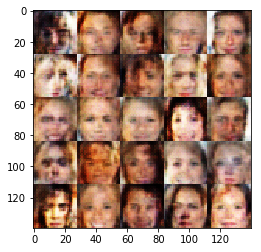

Epoch 0/1... Step: 6210... Discriminator Loss: 1.4157... Generator Loss: 0.6808
Epoch 0/1... Step: 6220... Discriminator Loss: 1.4466... Generator Loss: 0.6213
Epoch 0/1... Step: 6230... Discriminator Loss: 1.4181... Generator Loss: 0.6645
Epoch 0/1... Step: 6240... Discriminator Loss: 1.3777... Generator Loss: 0.7382
Epoch 0/1... Step: 6250... Discriminator Loss: 1.4002... Generator Loss: 0.6970
Epoch 0/1... Step: 6260... Discriminator Loss: 1.4106... Generator Loss: 0.7420
Epoch 0/1... Step: 6270... Discriminator Loss: 1.4261... Generator Loss: 0.6104
Epoch 0/1... Step: 6280... Discriminator Loss: 1.3886... Generator Loss: 0.6953
Epoch 0/1... Step: 6290... Discriminator Loss: 1.4520... Generator Loss: 0.6887
Epoch 0/1... Step: 6300... Discriminator Loss: 1.3289... Generator Loss: 0.8380


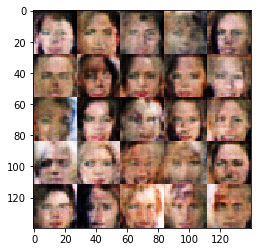

Epoch 0/1... Step: 6310... Discriminator Loss: 1.4290... Generator Loss: 0.6909
Epoch 0/1... Step: 6320... Discriminator Loss: 1.4589... Generator Loss: 0.8182
Epoch 0/1... Step: 6330... Discriminator Loss: 1.4684... Generator Loss: 0.6339


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。